In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os.path

from os import getcwd
import numpy as np
import pandas as pd
import hdf5storage
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import savemat, loadmat
import math
from scipy.fftpack import fft, ifft
from scipy.stats import zscore, f_oneway
#import samplerate
import multiprocessing as mp
from scipy.signal import resample
import random
import pyreadr
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score
import statsmodels.api as sm
import scipy
import matplotlib.patches as mpatches
import statsmodels.stats.multitest as multitest
import mne
from mne.preprocessing import ICA
from mne.time_frequency import tfr_morlet
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [2]:
def get_info(field_num):
    field = []
    for item in range(trial_num):
        field.append(group_data['DATA'][0][item][field_num][0])
    return pd.DataFrame(field)

def load_time_series(subject, session, unit_id):
    #subj_mat = hdf5storage.loadmat(f"Z:\DBS\\{subject}\Preprocessed Data\SpikeSorting\\{subject}_ft_raw_spike.mat")
    subj_mat = hdf5storage.loadmat(f"/Volumes/Nexus/DBS/{subject}/Preprocessed Data/SpikeSorting/{subject}_ft_raw_spike.mat")
    time_data = subj_mat['IFR'][0]['time'][0][int(session-1)][0]
    neural_data = subj_mat['IFR'][0]['trial'][0][int(session-1)][int(unit_id-1)]
    
    time_data = time_data[~np.isnan(neural_data)]
    neural_data = neural_data[~np.isnan(neural_data)]
    
    return time_data, neural_data

def get_df(time_point, neural_data, time_data, after=3.5, before=1.5, fs=1000):
    dfs = []
    time_point = time_point[time_point<time_data.max()-2][time_point>time_data.min()+2]
    for item in time_point:
        for i2 in range(len(neural_data)):
            if time_data[i2] > item:
                dfs.append(neural_data[i2-int(before*fs):i2+int(after*fs)])
                break
    return np.array(dfs)

# function to convert to superscript
def get_super(x):
    normal = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-=()"
    super_s = "ᴬᴮᶜᴰᴱᶠᴳᴴᴵᴶᴷᴸᴹᴺᴼᴾQᴿˢᵀᵁⱽᵂˣʸᶻᵃᵇᶜᵈᵉᶠᵍʰᶦʲᵏˡᵐⁿᵒᵖ۹ʳˢᵗᵘᵛʷˣʸᶻ⁰¹²³⁴⁵⁶⁷⁸⁹⁺⁻⁼⁽⁾"
    res = x.maketrans(''.join(normal), ''.join(super_s))
    return x.translate(res)

In [3]:
def get_avg_spike(time_table, neural_data, time_data, fs=1000):
    time_point = time_table['starts']
    before = time_table['before_time']
    after = time_table['duration']
    dfs = []

    for item in range(len(neural_data)):
        if time_data[item] > time_point:
            dfs.append(neural_data[item-int(before*fs):item+int(after*fs)])
            break
    return np.mean(np.array(dfs))

In [4]:
#group_data = hdf5storage.loadmat(r"Z:\Commits\DBS_speech\Dev\U01SpikeAnalysis\data\group_data\group_data_narrow_09082021.mat")
#group_data = hdf5storage.loadmat(r"../../../../Macintosh HD/Users/yanming/Desktop/MGH BML/Sound-induced_STN_activity/manuscript/group_data_narrow_09082021.mat")
group_data = hdf5storage.loadmat(r"../../../../Macintosh HD/Users/yanming/Desktop/stn_auditory/group_data_narrow_09082021.mat")

trial_num = len(group_data['DATA'][0])

SubjectID = get_info(0)
SubjectID.columns = ['SubjectID']

session = get_info(1)
session.columns = ['session']

electrode = get_info(2)
electrode.columns = ['electrode']

unit_id = get_info(3)
unit_id.columns = ['unit_id']

unit = get_info(4)
unit.columns = ['unit']

RecType = get_info(5)
RecType.columns = ['RecType']

grade = get_info(6)
grade.columns = ['grade']

info = pd.concat([SubjectID, session, electrode, unit_id, unit, RecType, grade], axis=1)
info.head(2)
info.shape

SubjectID  session electrode  unit_id  unit RecType grade
0   DBS3001        1   micro_m        6     4      MU     B
1   DBS3001        2   micro_c        7     1      MU     C

(229, 7)

In [5]:
def get_produced_freq():
    produced_freq = pd.read_csv('all_freq.csv', index_col='id')
    d = {'ah':0, 'oo':1, 'ee':2}
    produced_freq['stim_factor'] = produced_freq.stim.map(d)
    produced_freq['spl'] = 20*np.log10(produced_freq['rms_audio_p'])
    produced_freq = produced_freq.dropna().reset_index(drop=1)

    produced_freq['before_time'] = np.nan
    for item in range(1, produced_freq.shape[0]):
        if produced_freq.syl_id[item] == 2:
            if produced_freq.syl_id[item-1] == 1:
                produced_freq.before_time[item] = produced_freq.starts[item] - produced_freq.ends[item-1]
        elif produced_freq.syl_id[item] == 3:
            if produced_freq.syl_id[item-1] == 2:
                produced_freq.before_time[item] = produced_freq.starts[item] - produced_freq.ends[item-1]

    for item in range(1, produced_freq.shape[0]):
        if produced_freq.syl_id[item] == 1:
            if produced_freq.syl_id[item+1] == 2:
                if produced_freq.syl_id[item+2] == 3:
                    produced_freq.before_time[item] = (produced_freq.before_time[item+1] + 
                                                       produced_freq.before_time[item+2])/2

    produced_freq.before_time[0] = (produced_freq.before_time[1] + produced_freq.before_time[2])/2
    produced_freq = produced_freq.dropna().reset_index(drop=1)
    return produced_freq

produced_df = get_produced_freq()
produced_df.shape
produced_df.head(2)

(41210, 26)

starts          ends  duration    cons_onset  trial_id  session_id  \
0  36145.009713  36145.184457  0.174745  36145.009713         1           1   
1  36145.494905  36145.643055  0.148150  36145.494905         1           1   

   syl_id  channel  fundamental_freq   type  ...  subject         freq2  \
0       1  audio_p        142.196732  vowel  ...  DBS3001  20219.910530   
1       2  audio_p        140.861581  vowel  ...  DBS3001  19841.984898   

  discont contrun_id           t            t2            t3  stim_factor  \
0       1          1 -195.420094  38189.013071 -7.462901e+06            0   
1       0          1 -194.934901  37999.615755 -7.407451e+06            1   

         spl  before_time  
0 -18.178208     0.404081  
1 -21.894791     0.310448  

[2 rows x 26 columns]

In [6]:
def get_subj_table(produced_freq, number_elec, info, timing_subj, neural_subj):
    SUBJ = info.iloc[number_elec, 0]
    SESS = info.iloc[number_elec, 1]
    subj_table = produced_freq[produced_freq.subject == SUBJ].reset_index(drop=1)
    subj_table = subj_table[subj_table.session_id == SESS].reset_index(drop=1)
    subj_table = subj_table[subj_table.starts > timing_subj.min()+3.5].reset_index(drop=1)
    subj_table = subj_table[subj_table.starts < timing_subj.max()-3.5].reset_index(drop=1)

        
    subj_table['avg_spike'] = np.nan
    for trial in range(subj_table.shape[0]):
        if subj_table.ends[trial] < timing_subj.max() - 3.5:
            if subj_table.starts[trial] > timing_subj.min() + 3.5:
                subj_table.avg_spike[trial] = get_avg_spike(subj_table.iloc[trial], 
                                                            neural_subj, timing_subj)
    subj_table = subj_table.dropna().reset_index(drop=1)
    
    subj_table['t_z'] = (subj_table['t'] - subj_table['t'].mean())/subj_table['t'].std(ddof=0)
    stim_vol_mean = subj_table['stim_volume'].mean()
    subj_table['stim_vol_z'] = (subj_table['stim_volume'] - 
                                   stim_vol_mean)/subj_table['stim_volume'].std(ddof=0)
    if subj_table['stim_volume'].unique().shape[0]==1:
        subj_table['stim_vol_z'] = 0
        

    subj_table['syl_id_z'] = (subj_table['syl_id'] - 
                              subj_table['syl_id'].mean())/subj_table['syl_id'].std(ddof=0)
    subj_table['spl_z'] = (subj_table['spl'] - 
                           subj_table['spl'].mean())/subj_table['spl'].std(ddof=0)
    stim_fac_mean = subj_table['stim_factor'].mean()
    subj_table['stim_z'] = (subj_table['stim_factor'] - 
                                   stim_fac_mean)/subj_table['stim_factor'].std(ddof=0)
    fund_freq_mean = subj_table['fundamental_freq'].mean()
    subj_table['pitch_z'] = (subj_table['fundamental_freq'] - 
                             fund_freq_mean)/subj_table['fundamental_freq'].std(ddof=0)
    subj_table['pitch_spl_z'] = subj_table['pitch_z']*subj_table['spl_z']

    return subj_table

In [7]:
def get_subj_df_cue(subject, sess, subj_table):
    #cue_df = pd.read_csv(f'Z:\DBS\\{subject}\Preprocessed Data\Sync\\annot\\{subject}_stimulus_syllable.txt', sep='	', index_col='id')
    cue_df = pd.read_csv(f'/Volumes/Nexus/DBS/{subject}/Preprocessed Data/Sync/annot/{subject}_stimulus_syllable.txt', sep='	', index_col='id')
    cue_df = cue_df[cue_df['session_id']==sess].reset_index(drop=1)
    subj_table_cue = pd.merge(subj_table, cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")
    return subj_table_cue

def find_rest_time(subject_df):
    resting_time = subject_df[subject_df['syl_id'] == 1]['starts_y'] - 1
    return resting_time

def nansem(a, axis=1):
    return np.nanstd(a, axis=0)/np.sqrt(a.shape[axis])

def find_full_3_trial(subj_table, timing_subj):
    good_trial = []
    subj_table = subj_table.dropna()
    subj_table = subj_table[subj_table['starts_y'] > timing_subj.min() + 3.5]
    subj_table = subj_table[subj_table['ends_x'] < timing_subj.max() - 3.5]
    for item in subj_table['trial_id'].unique():
        if subj_table[subj_table['trial_id'] == item].shape[0] == 3:
            good_trial.append(item)
    return subj_table[subj_table['trial_id'].isin(good_trial)]

In [8]:
produced_df

starts          ends  duration    cons_onset  trial_id  \
0      36145.009713  36145.184457  0.174745  36145.009713         1   
1      36145.494905  36145.643055  0.148150  36145.494905         1   
2      36146.140770  36146.398870  0.258100  36146.140770         1   
3      36150.160670  36150.280090  0.119420  36150.160670         2   
4      36150.561600  36150.699400  0.137800  36150.561600         2   
...             ...           ...       ...           ...       ...   
41205  63652.680773  63652.765971  0.085199  63652.680773       119   
41206  63653.198991  63653.395638  0.196647  63653.198991       119   
41207  63657.740729  63657.858428  0.117698  63657.740729       120   
41208  63658.485245  63658.610393  0.125148  63658.485245       120   
41209  63659.292759  63659.339959  0.047199  63659.292759       120   

       session_id  syl_id  channel  fundamental_freq   type  ...  subject  \
0               1       1  audio_p        142.196732  vowel  ...  DBS3001   
1               1       2  audio_p        140.861581  vowel  ...  DBS3001   
2               1       3  audio_p        125.296315  vowel  ...  DBS3001   
3               1       1  audio_p        120.084566  vowel  ...  DBS3001   
4               1       2  audio_p        114.036614  vowel  ...  DBS3001   
...           ...     ...      ...               ...    ...  ...      ...   
41205           3       2  audio_p         96.755589  vowel  ...  DBS4088   
41206           3       3  audio_p         79.075877  vowel  ...  DBS4088   
41207           3       1  audio_p         65.531104  vowel  ...  DBS4088   
41208           3       2  audio_p         61.650452  vowel  ...  DBS4088   
41209           3       3  audio_p         89.753783  vowel  ...  DBS4088   

              freq2 discont contrun_id           t             t2  \
0      20219.910530       1          1 -195.420094   38189.013071   
1      19841.984898       0          1 -194.934901   37999.615755   
2      15699.166596       0          1 -194.289036   37748.229636   
3      14420.302885       0          1 -190.269136   36202.344238   
4      13004.349366       0          1 -189.868206   36049.935773   
...             ...     ...        ...         ...            ...   
41205   9361.643982       0        135  365.454650  133557.101115   
41206   6252.994374       0        135  365.972868  133936.140283   
41207   4294.325529       0        135  370.514607  137281.073704   
41208   3800.778220       0        135  371.259122  137833.335712   
41209   8055.741512       0        135  372.066637  138433.582153   

                 t3  stim_factor        spl  before_time  
0     -7.462901e+06            0 -18.178208     0.404081  
1     -7.407451e+06            1 -21.894791     0.310448  
2     -7.334067e+06            2 -17.693455     0.497715  
3     -6.888189e+06            2 -21.375089     0.332191  
4     -6.844737e+06            0 -22.018243     0.281510  
...             ...          ...        ...          ...  
41205  4.880906e+07            2 -24.539991     0.288284  
41206  4.901699e+07            1 -30.398685     0.433019  
41207  5.086464e+07            2 -28.682984     0.654592  
41208  5.117188e+07            0 -26.528452     0.626817  
41209  5.150652e+07            1 -25.180207     0.682366  

[41210 rows x 26 columns]

In [9]:
cue_unit = pd.read_csv('cue_unit.csv', index_col=0)
subj_unique = cue_unit.SubjectID.unique()[2:]

In [10]:
subj_unique

array(['DBS3003', 'DBS3004', 'DBS3005', 'DBS3008', 'DBS3010', 'DBS3011',
       'DBS3012', 'DBS3014', 'DBS3015', 'DBS3017', 'DBS3018', 'DBS3019',
       'DBS3020', 'DBS3022', 'DBS3023', 'DBS3024', 'DBS3026', 'DBS3027',
       'DBS3028', 'DBS3029', 'DBS3030', 'DBS3031', 'DBS3032'],
      dtype=object)

In [11]:
all_subj_df = pd.DataFrame()
for SUBJ in subj_unique:
    subj_table = produced_df[produced_df.subject == SUBJ].reset_index(drop=1)
    #cue_df = pd.read_csv(f'Z:\DBS\\{subject}\Preprocessed Data\Sync\\annot\\{subject}_stimulus_syllable.txt', sep='	', index_col='id')
    cue_df = pd.read_csv(f'/Volumes/Nexus/DBS/{SUBJ}/Preprocessed Data/Sync/annot/{SUBJ}_stimulus_syllable.txt', sep='	', index_col='id')
    subj_table_cue = pd.merge(subj_table, cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")
    #all_subj_df = all_subj_df.concat(subj_table_cue)
    all_subj_df = pd.concat([all_subj_df, subj_table_cue], ignore_index=True)
    
all_subj_df['cue_speech_lag'] = all_subj_df.starts_x - all_subj_df.starts_y
all_subj_df_1 = all_subj_df[all_subj_df.syl_id==1]

In [12]:
all_subj_triplet = pd.DataFrame()
for SUBJ in subj_unique:
    subj_table = produced_df[produced_df.subject == SUBJ].reset_index(drop=1)
    #cue_df = pd.read_csv(f'Z:\DBS\\{subject}\Preprocessed Data\Sync\\annot\\{subject}_stimulus_syllable.txt', sep='	', index_col='id')
    cue_df = pd.read_csv(f'/Volumes/Nexus/DBS/{SUBJ}/Preprocessed Data/Sync/annot/{SUBJ}_stimulus_syllable.txt', sep='	', index_col='id')
    subj_table_cue = pd.merge(subj_table, cue_df, on=['session_id', 'trial_id'], how="inner")
    #all_subj_triplet = all_subj_triplet.append(subj_table_cue)
    all_subj_triplet = pd.concat([all_subj_triplet, subj_table_cue], ignore_index=True)


all_subj_triplet['cue_speech_lag'] = all_subj_triplet.starts_x - all_subj_triplet.starts_y


In [13]:
all_subj_df_1.cue_speech_lag.mean()
all_subj_df_1.cue_speech_lag.std()

2.1653028695714713

0.30446765512758633

In [21]:
len(all_subj_df_1.subject.unique())

23

In [43]:
 (n_subj+1)/2

12.0

In [44]:
np.linspace(1, n_subj, int((n_subj+1)/2))

array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21., 23.])

In [15]:
import matplotlib.patches as patches


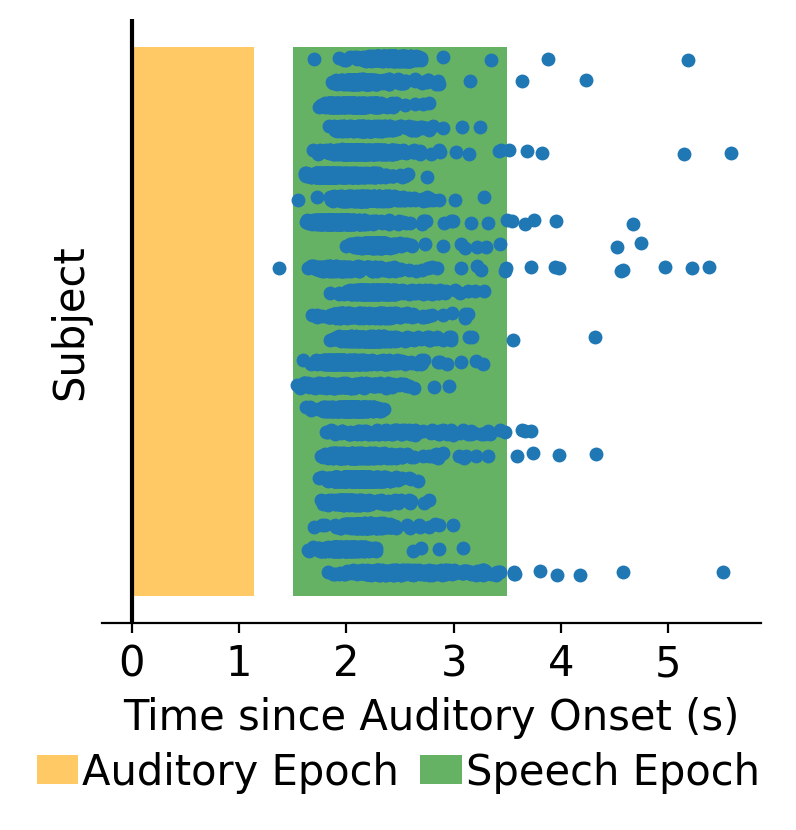

In [63]:
fig, axs = plt.subplots(1, 1, figsize=(4.25, 4), dpi=200)
fig.patch.set_alpha(0)
axs.patch.set_alpha(0)

n_subj = len(all_subj_df_1.subject.unique())

strip = sns.stripplot(data=all_subj_df_1, x='cue_speech_lag', y='subject', 
            ax=axs, dodge=1, label='Speech Onset')

#axs.axvline(all_subj_df_1.duration_x.mean()+1, label='Auditory Offset', c='k', linestyle='--')
axs.axvline(0, label='Auditory Onset', c='k')
axs.set_ylabel('Subject', fontsize=15)
axs.set_xlabel('Time since Auditory Onset (s)', fontsize=15)
handles, labels = axs.get_legend_handles_labels()


#axs.set_yticks(np.linspace(0, n_subj-1, int((n_subj+1)/2)))
#axs.set_yticklabels(np.linspace(1, n_subj, int((n_subj+1)/2), dtype=int), fontsize=15)
axs.set_yticks([])
sns.despine(ax=axs, top=True, right=True, left=True, bottom=False)
axs.set_xticks(np.linspace(0, 5, 6))
axs.set_xticklabels(np.linspace(0, 5, 6, dtype=int), fontsize=15)

# Create a Rectangle patch
auditory_epoch = patches.Rectangle((0, axs.get_ylim()[1]), all_subj_df_1.duration_x.mean()+1, axs.get_ylim()[0]+1, 
                         linewidth=1, edgecolor='none', facecolor='orange', alpha=0.6, label='Auditory Epoch')
speech_epoch = patches.Rectangle((1.5, axs.get_ylim()[1]), 2, axs.get_ylim()[0]+1, 
                         linewidth=1, edgecolor='none', facecolor='green', alpha=0.6, label='Speech Epoch')
# Add the patch to the Axes
axs.add_patch(auditory_epoch)
axs.add_patch(speech_epoch)

use_handle = handles[-1:]
use_label = labels[-1:]

legend = plt.legend(handles = [use_handle, auditory_epoch, speech_epoch], 
                    labels = [use_label, auditory_epoch.get_label(), speech_epoch.get_label()], 
                    fontsize=15, frameon=False, ncol=2, 
           loc='upper center', bbox_to_anchor=(0.45, -0.15), handlelength=1, 
           handletextpad=0.1, columnspacing=0.5)
legend.get_frame().set_alpha(None)

plt.plot();

In [60]:
use_label
use_handle
auditory_epoch.get_label()
strip.get_label()

['Auditory Onset']

'Auditory Epoch'

''

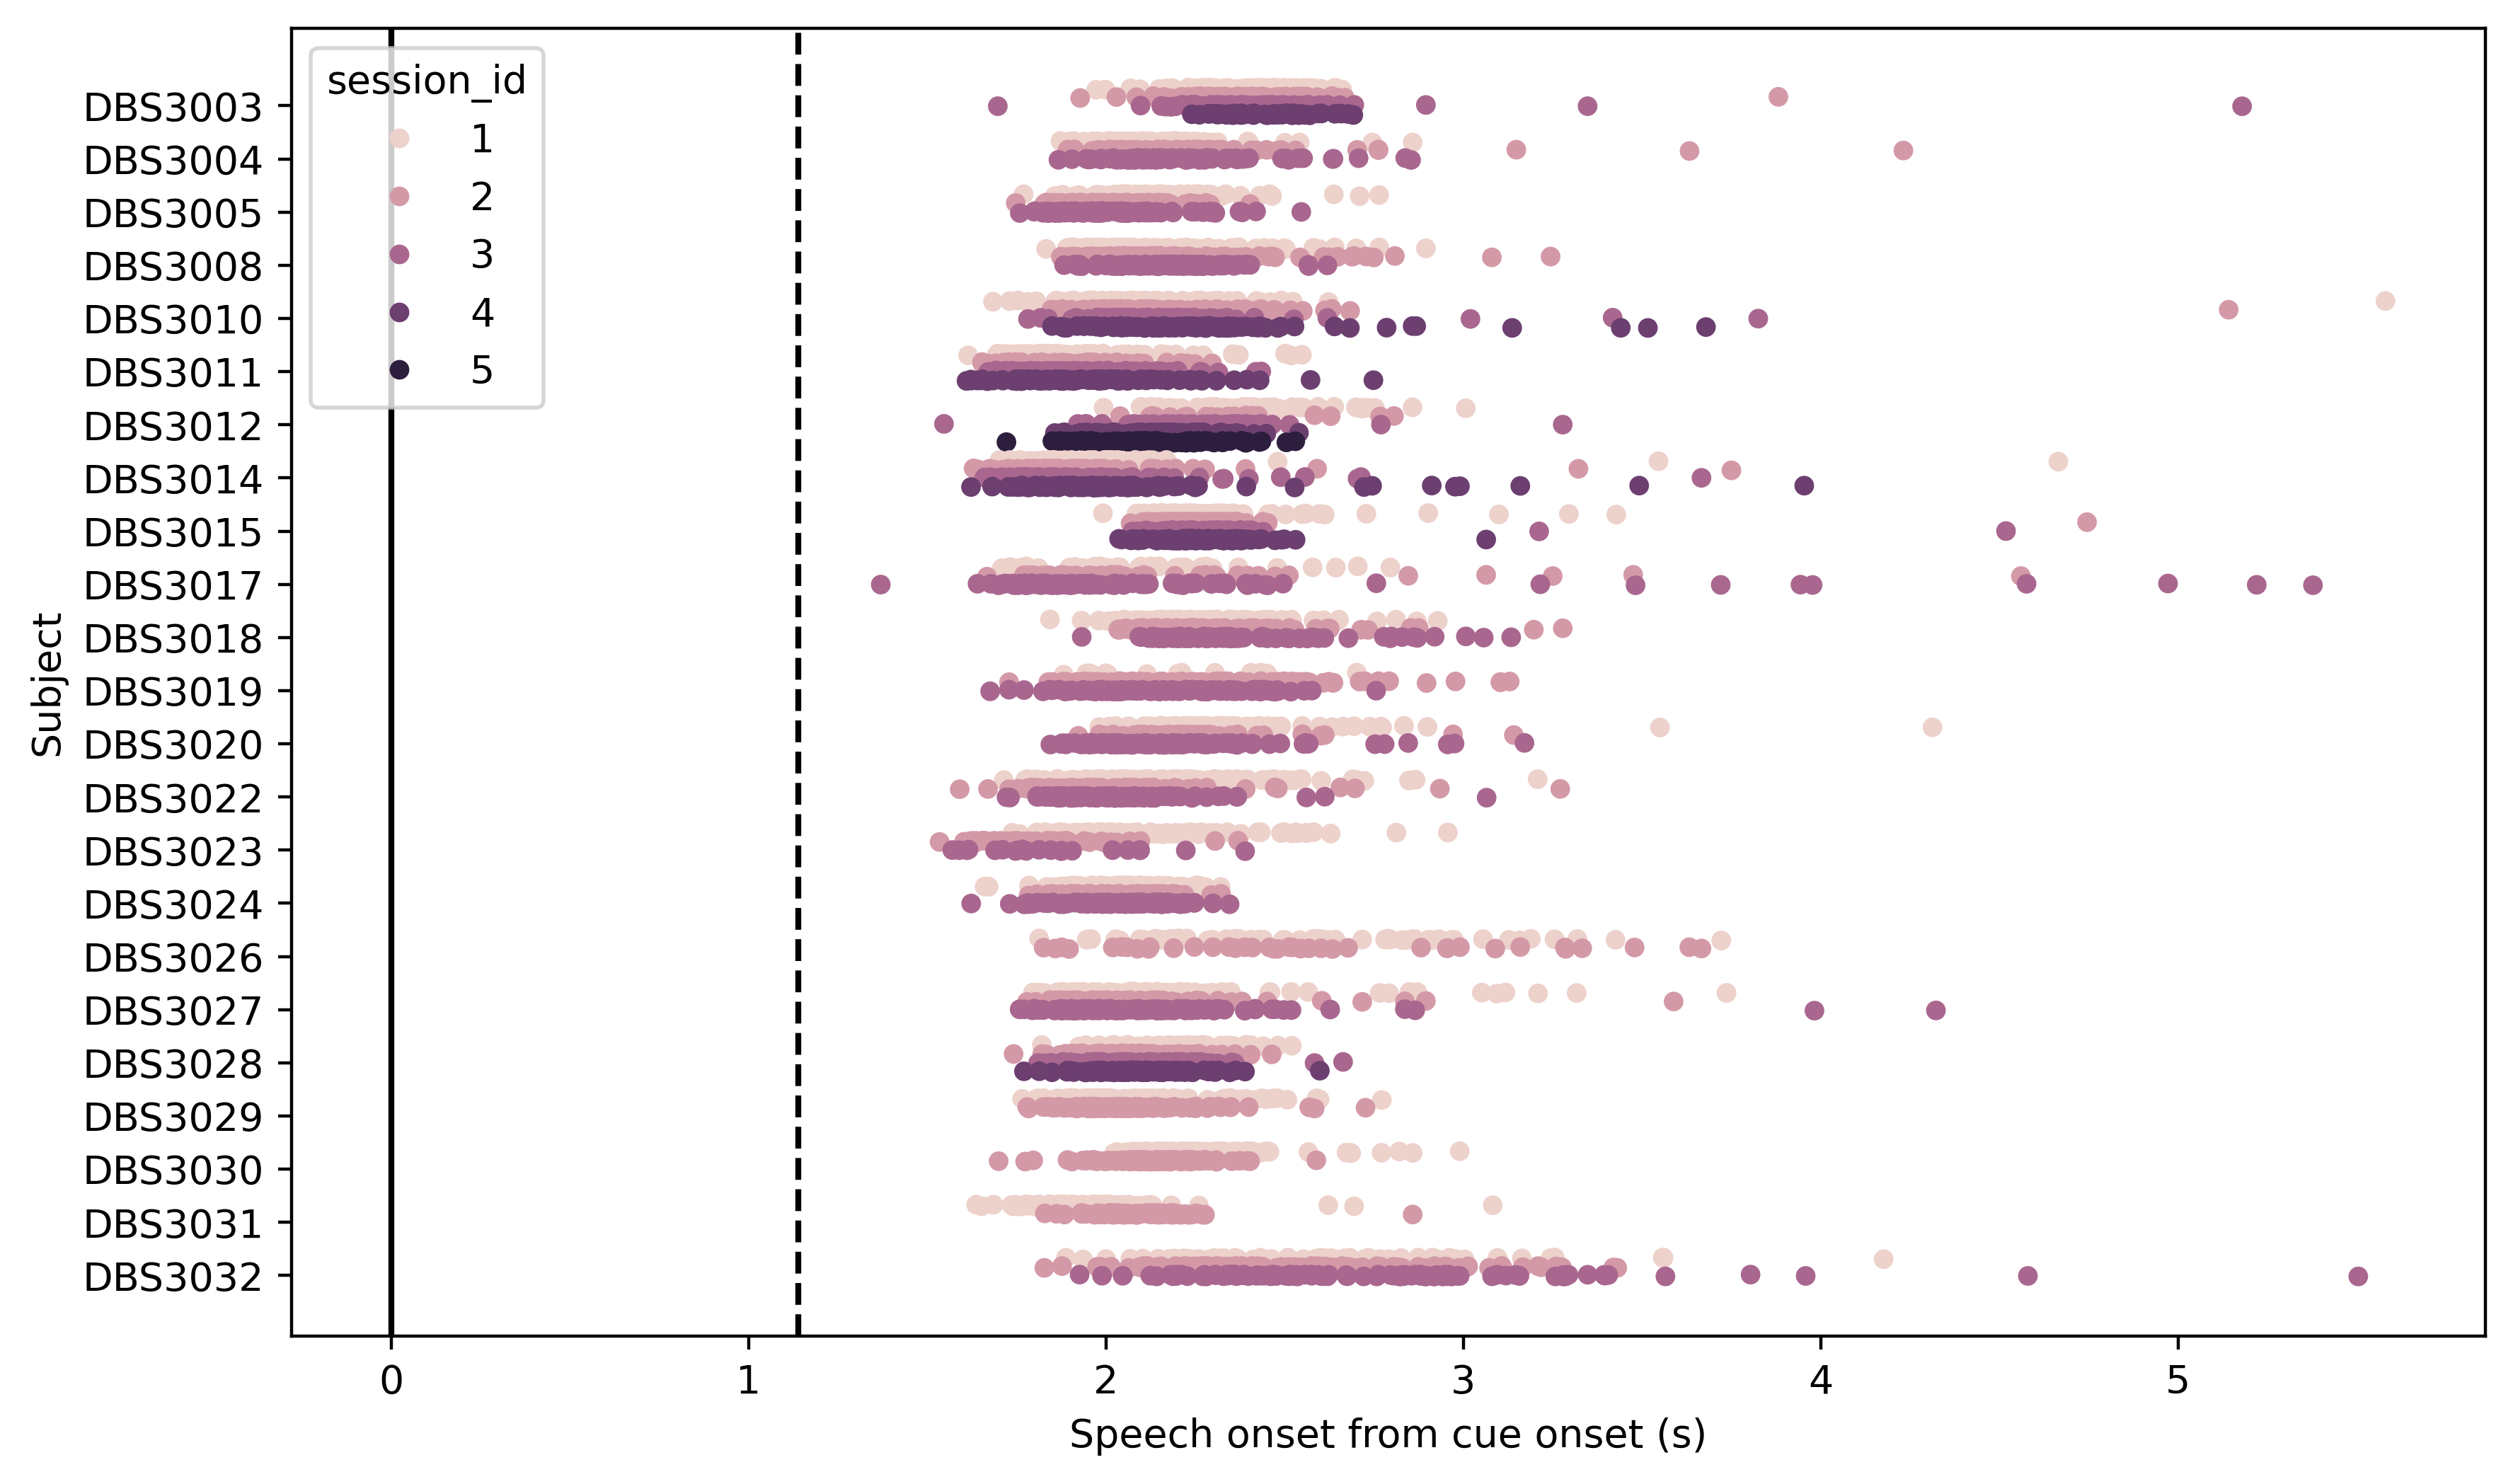

In [13]:
fig, axs = plt.subplots(1, 1, figsize=(10, 6), dpi=200)

sns.stripplot(data=all_subj_df_1, x='cue_speech_lag', y='subject', hue='session_id', 
            ax=axs, dodge=1)

axs.axvline(all_subj_df_1.duration_x.mean()+1, label='Cue offset', c='k', linestyle='--')
axs.axvline(0, label='Cue onset', c='k')
axs.set_ylabel('Subject')
axs.set_xlabel('Speech onset from cue onset (s)')

#plt.legend()
plt.plot();

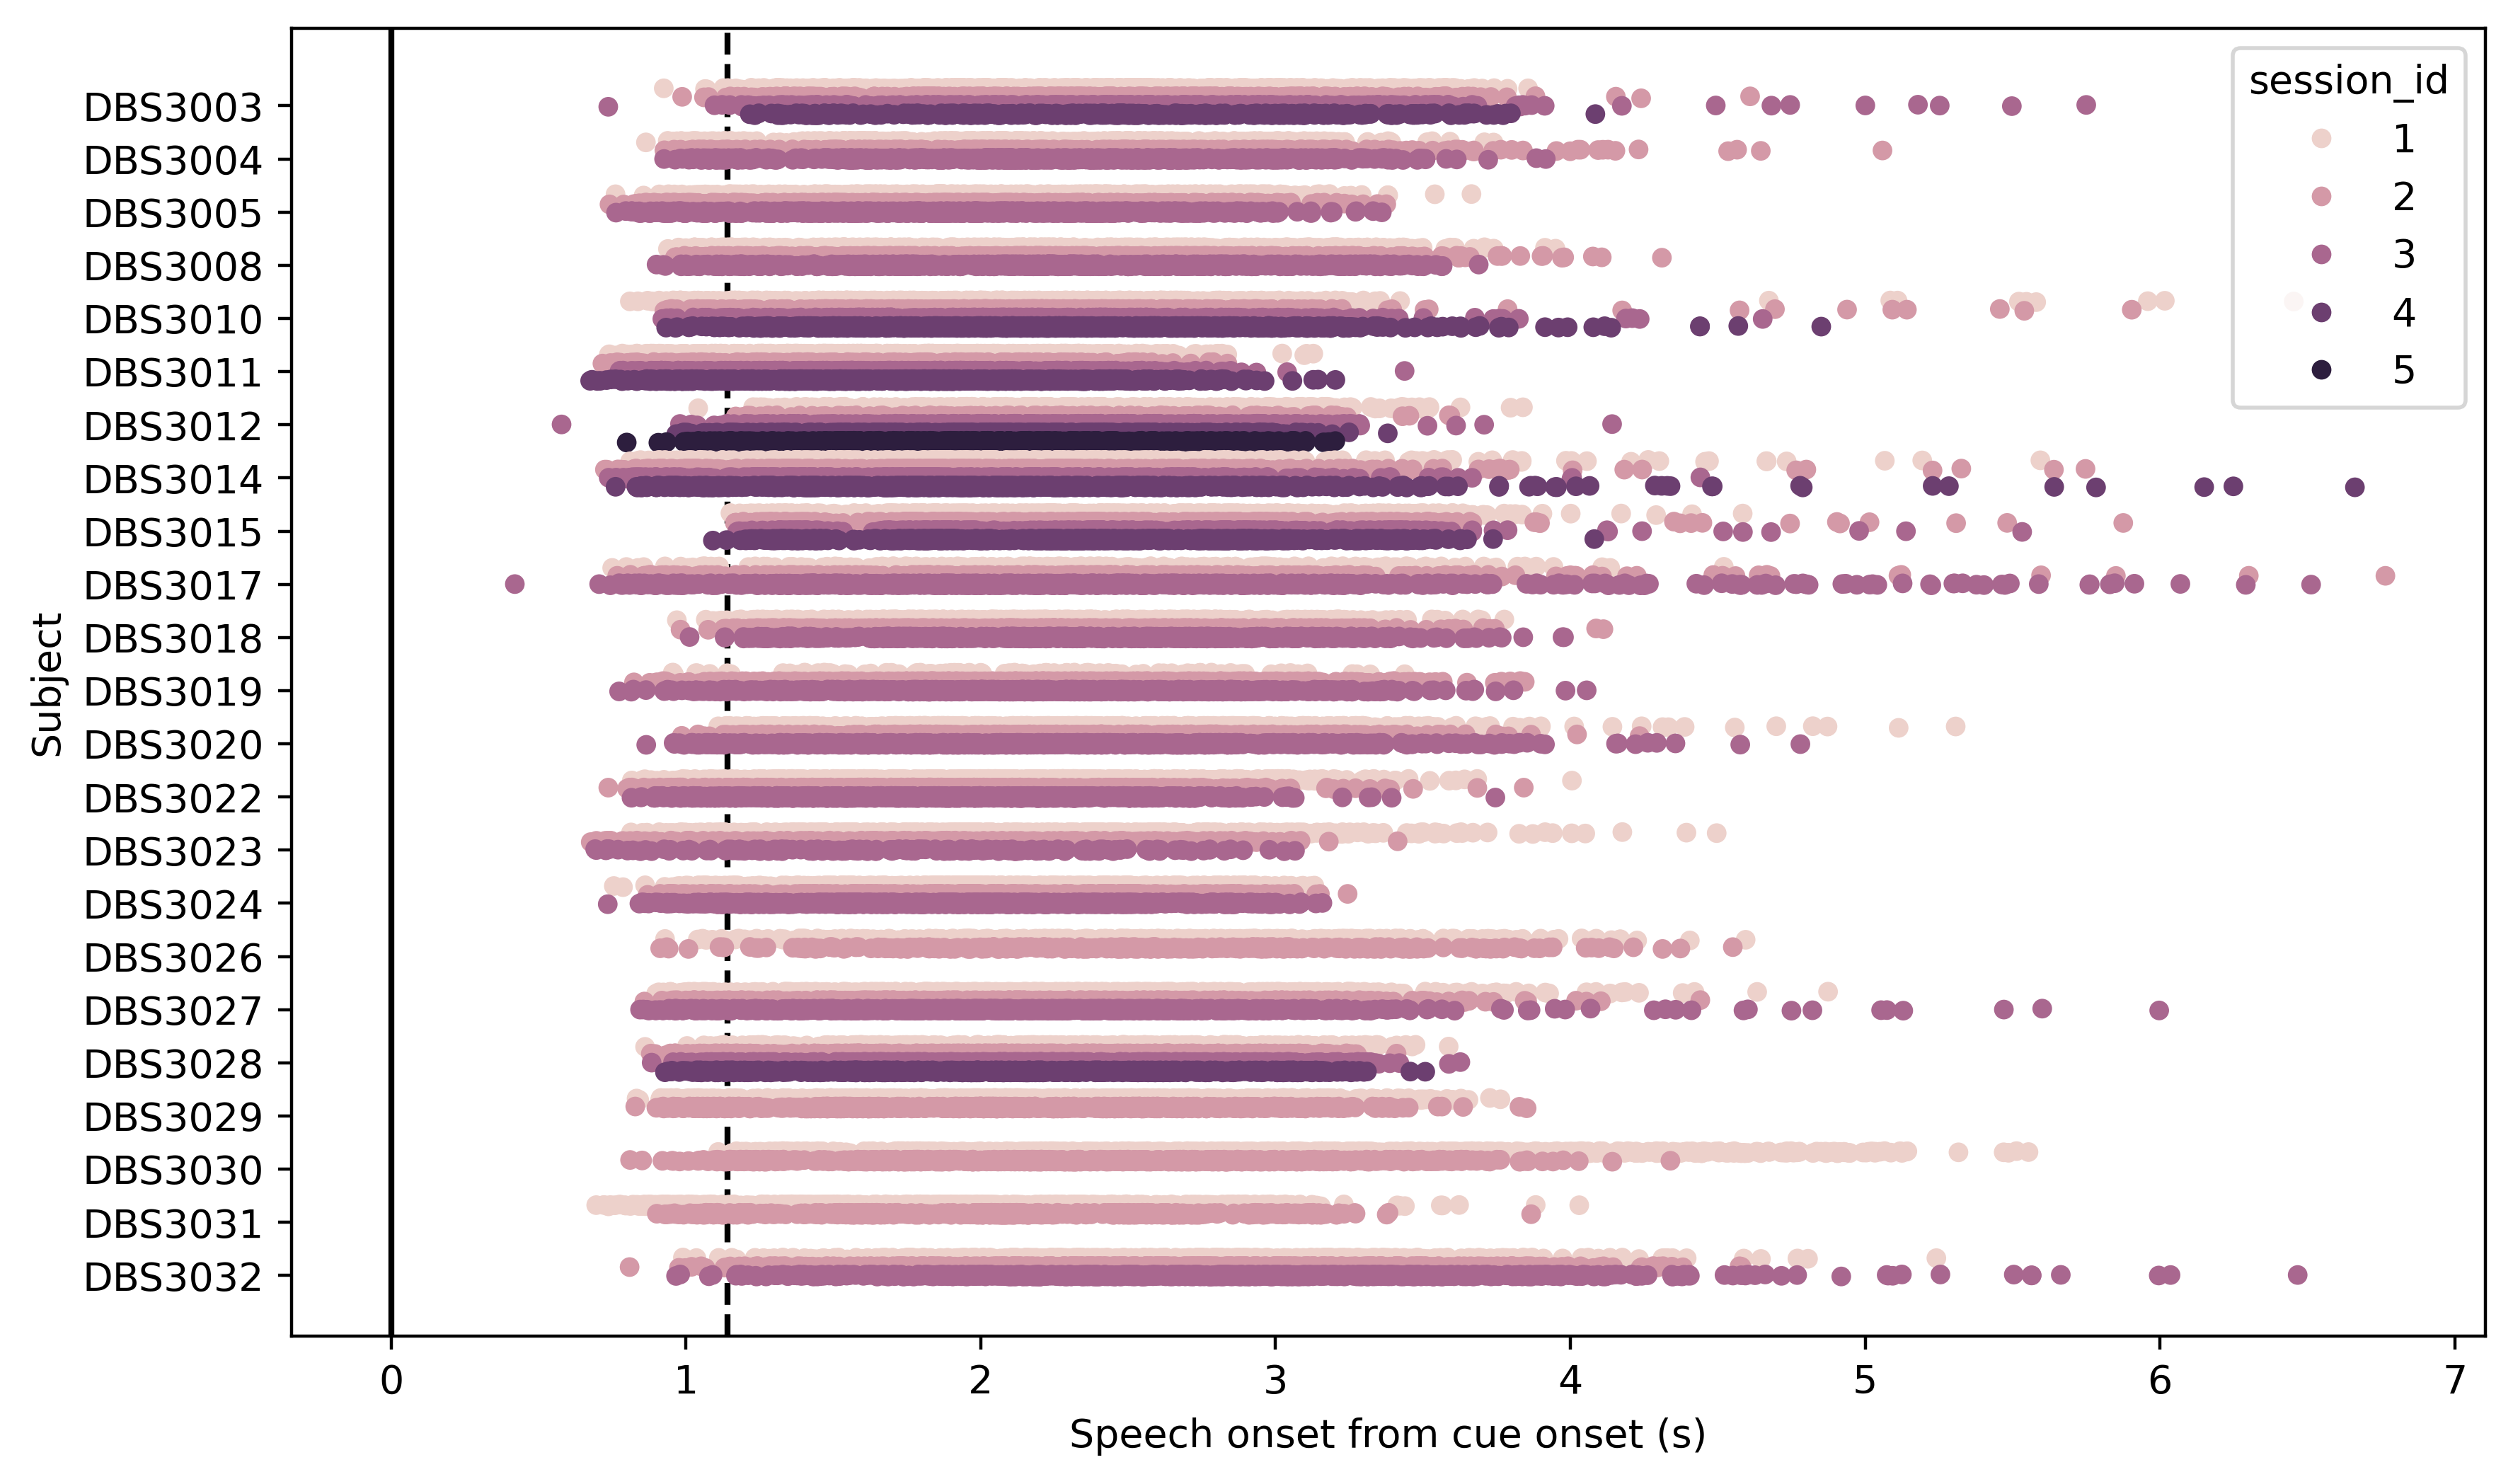

In [23]:
fig, axs = plt.subplots(1, 1, figsize=(10, 6), dpi=200)

sns.stripplot(data=all_subj_triplet, x='cue_speech_lag', y='subject', hue='session_id', 
            ax=axs, dodge=1)

axs.axvline(all_subj_triplet.duration_x.mean()+1, label='Cue offset', c='k', linestyle='--')
axs.axvline(0, label='Cue onset', c='k')
axs.set_ylabel('Subject')
axs.set_xlabel('Speech onset from cue onset (s)')

#plt.legend()
plt.plot();

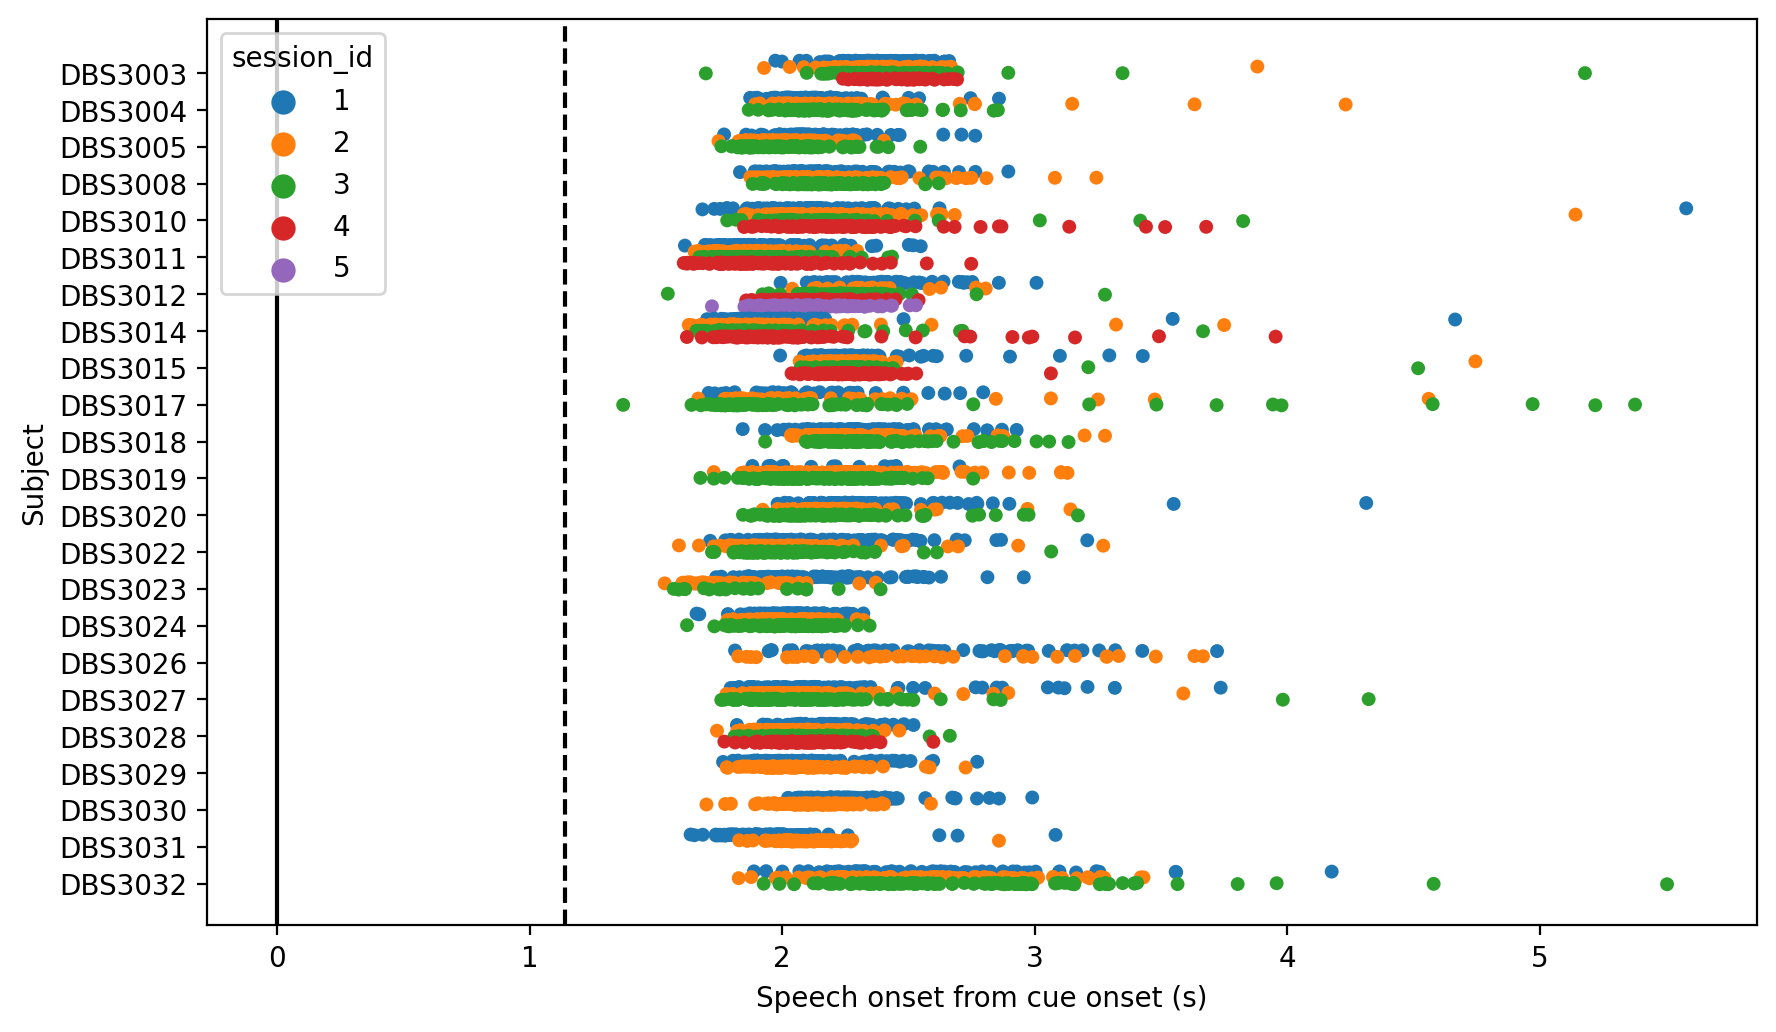

In [88]:
fig, axs = plt.subplots(1, 1, figsize=(10, 6), dpi=200)

sns.stripplot(data=all_subj_df_1, x='cue_speech_lag', y='subject', hue='session_id', 
            ax=axs, dodge=1)

axs.axvline(all_subj_df_1.duration_x.mean()+1, label='Cue offset', c='k', linestyle='--')
axs.axvline(0, label='Cue onset', c='k')
axs.set_ylabel('Subject')
axs.set_xlabel('Speech onset from cue onset (s)')

#plt.legend()
plt.plot();

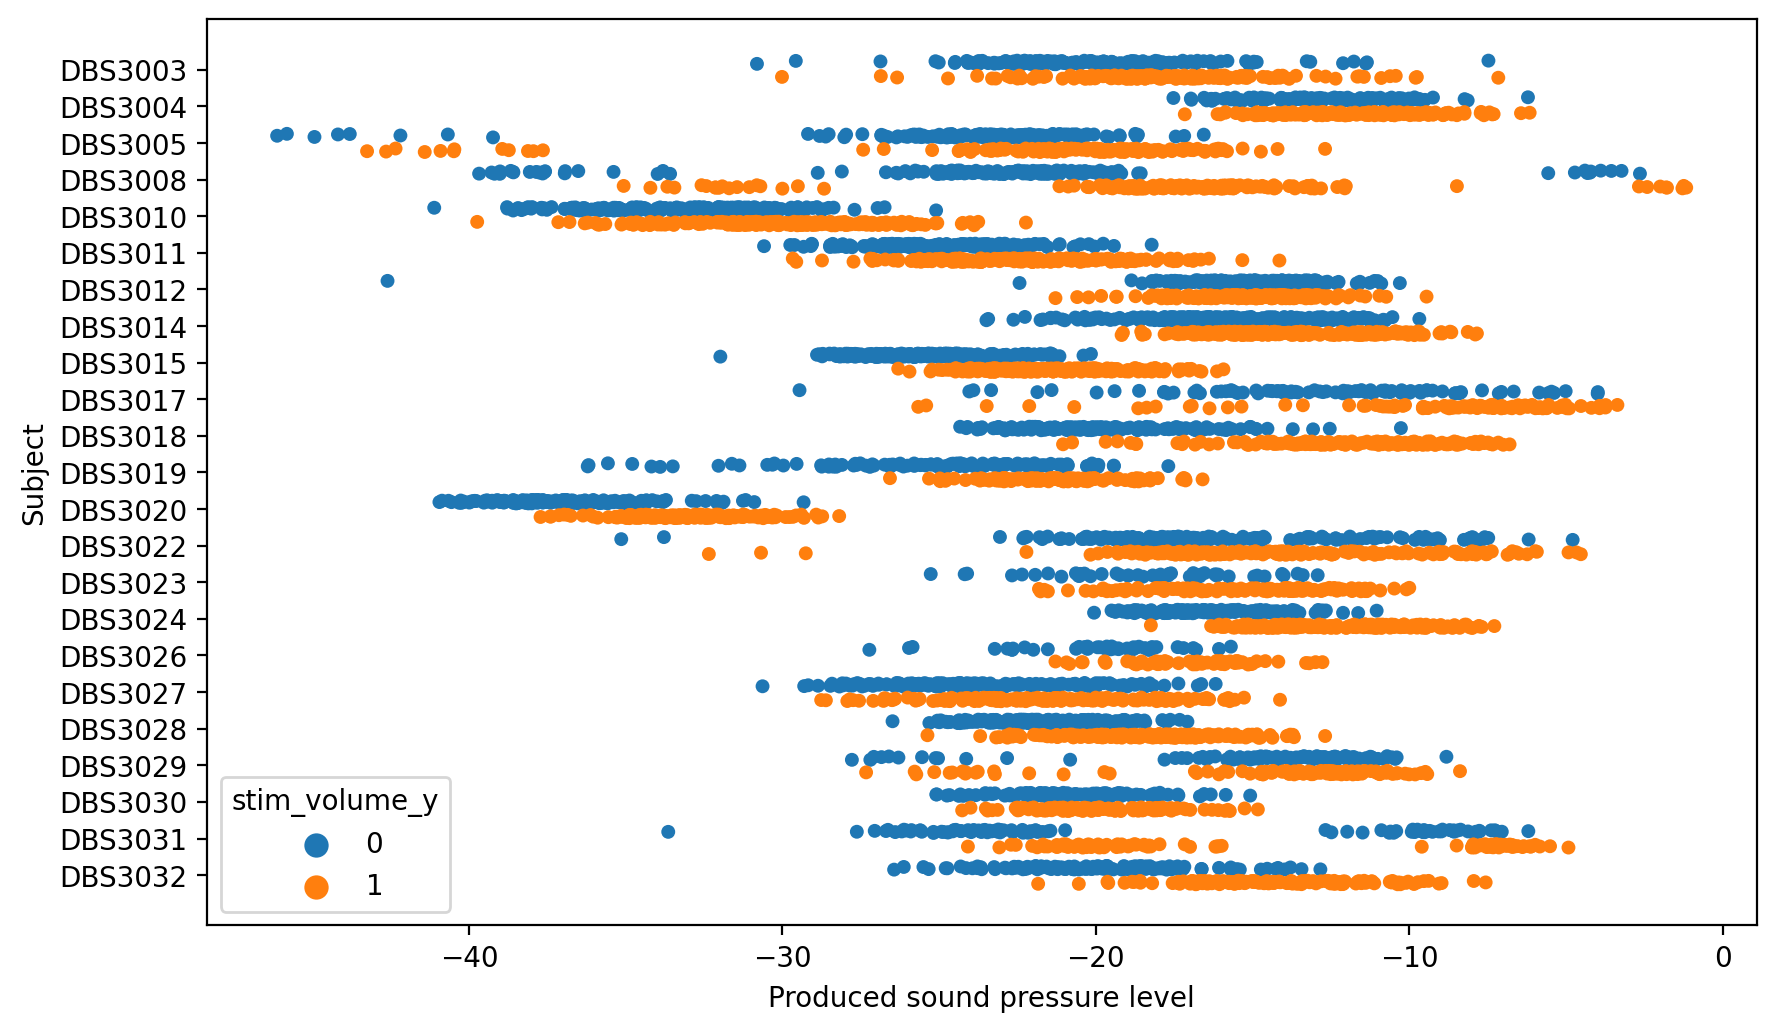

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(10, 6), dpi=200)

sns.stripplot(data=all_subj_df_1, x='spl', y='subject', hue='stim_volume_y', 
            ax=axs, dodge=1)

#axs.axvline(all_subj_df_1.duration_x.mean()+1, label='Cue offset', c='k', linestyle='--')
#axs.axvline(0, label='Cue onset', c='k')
axs.set_ylabel('Subject')
axs.set_xlabel('Produced sound pressure level')

#plt.legend()
plt.plot();

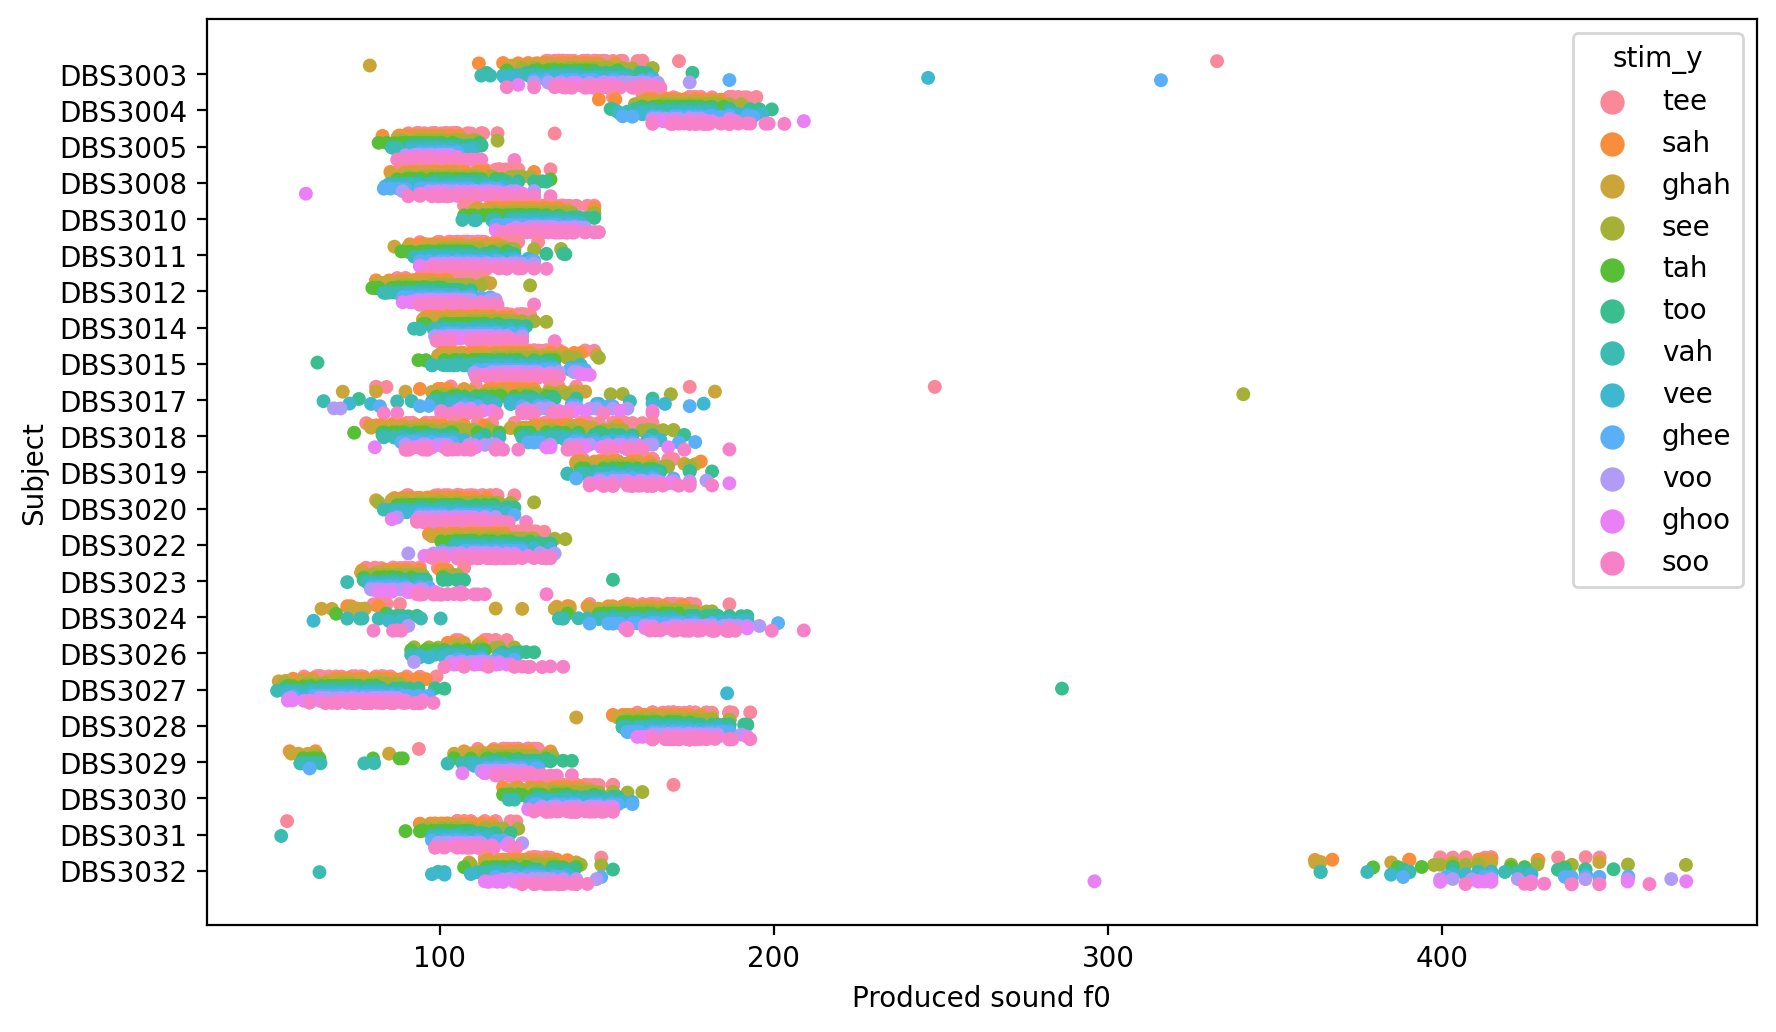

In [20]:
fig, axs = plt.subplots(1, 1, figsize=(10, 6), dpi=200)

sns.stripplot(data=all_subj_df_1, x='fundamental_freq', y='subject', hue='stim_y', 
            ax=axs, dodge=1)

#axs.axvline(all_subj_df_1.duration_x.mean()+1, label='Cue offset', c='k', linestyle='--')
#axs.axvline(0, label='Cue onset', c='k')
axs.set_ylabel('Subject')
axs.set_xlabel('Produced sound f0')

#plt.legend()
plt.plot();

In [ ]:
sns.stripplot(data=all_subj_df_1, x='cue_speech_lag', y='subject', hue='session_id', 
            ax=axs, dodge=1)

In [41]:
len(all_subj_df_1['subject'].unique())

23

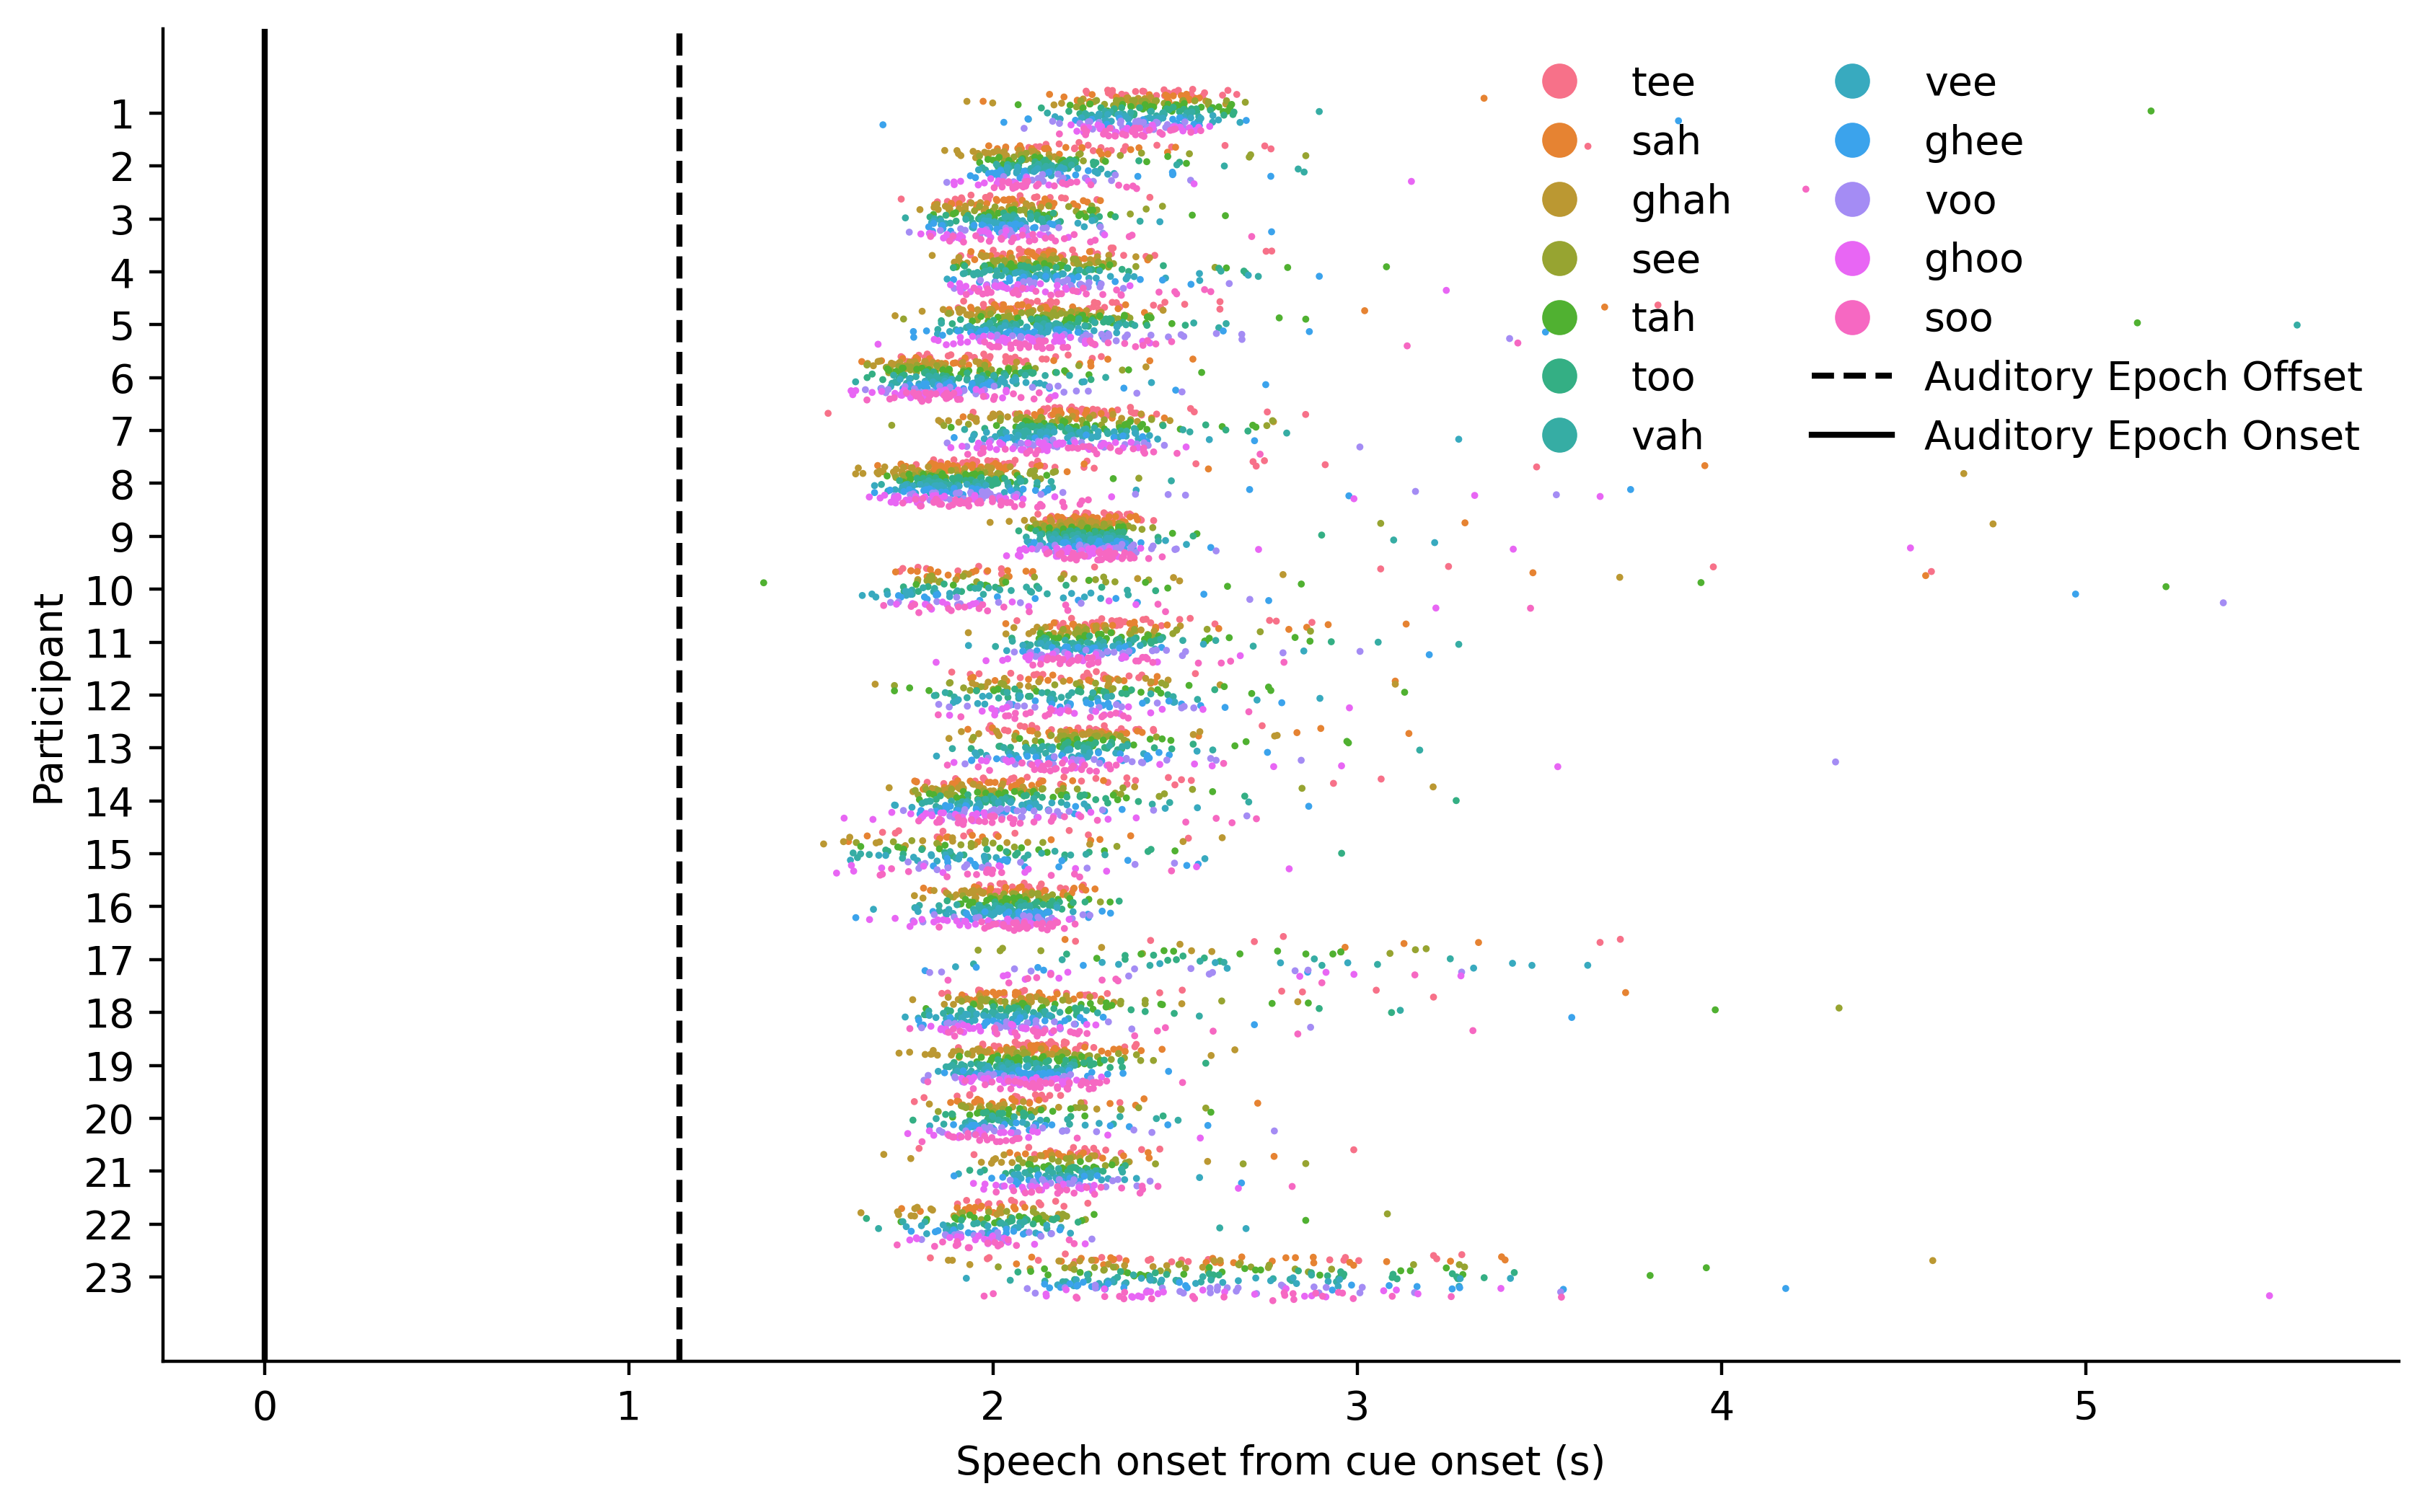

In [45]:
fig, axs = plt.subplots(1, 1, figsize=(10, 6), dpi=200)

sns.stripplot(data=all_subj_df_1, x='cue_speech_lag', y='subject', hue='stim_y', 
            ax=axs, dodge=1, jitter=1, size=1.75)
axs.patch.set_alpha(0)
fig.patch.set_alpha(0)
#axs.axvline(all_subj_df_1.duration_x.mean()+1, label='Cue offset', c='k', linestyle='--')
#axs.axvline(0, label='Cue onset', c='k')
axs.set_ylabel('Participant')
axs.set_xlabel('Speech onset from cue onset (s)')
axs.axvline(all_subj_df_1.duration_x.mean()+1, label='Auditory Epoch Offset', c='k', linestyle='--')
axs.axvline(0, label='Auditory Epoch Onset', c='k')
sns.despine(ax=axs, top=True, right=True)
plt.legend(loc=1, markerscale=5, frameon=False, ncol=2)
axs.set_yticklabels(np.linspace(1, 23, 23, dtype=int))
plt.plot();

In [106]:
all_subj_triplet.stim_y

0       teesoovah
1       teesoovah
2       teesoovah
3      sahteeghoo
4      sahteeghoo
          ...    
887    teegheetoo
888    teegheetoo
889    gheetahvoo
890    gheetahvoo
891    gheetahvoo
Name: stim_y, Length: 22323, dtype: object

In [108]:
all_subj_triplet.stim1.value_counts()

vee     1933
vah     1916
see     1913
soo     1881
tah     1870
voo     1854
too     1849
ghoo    1840
tee     1833
sah     1828
ghee    1825
ghah    1781
Name: stim1, dtype: int64

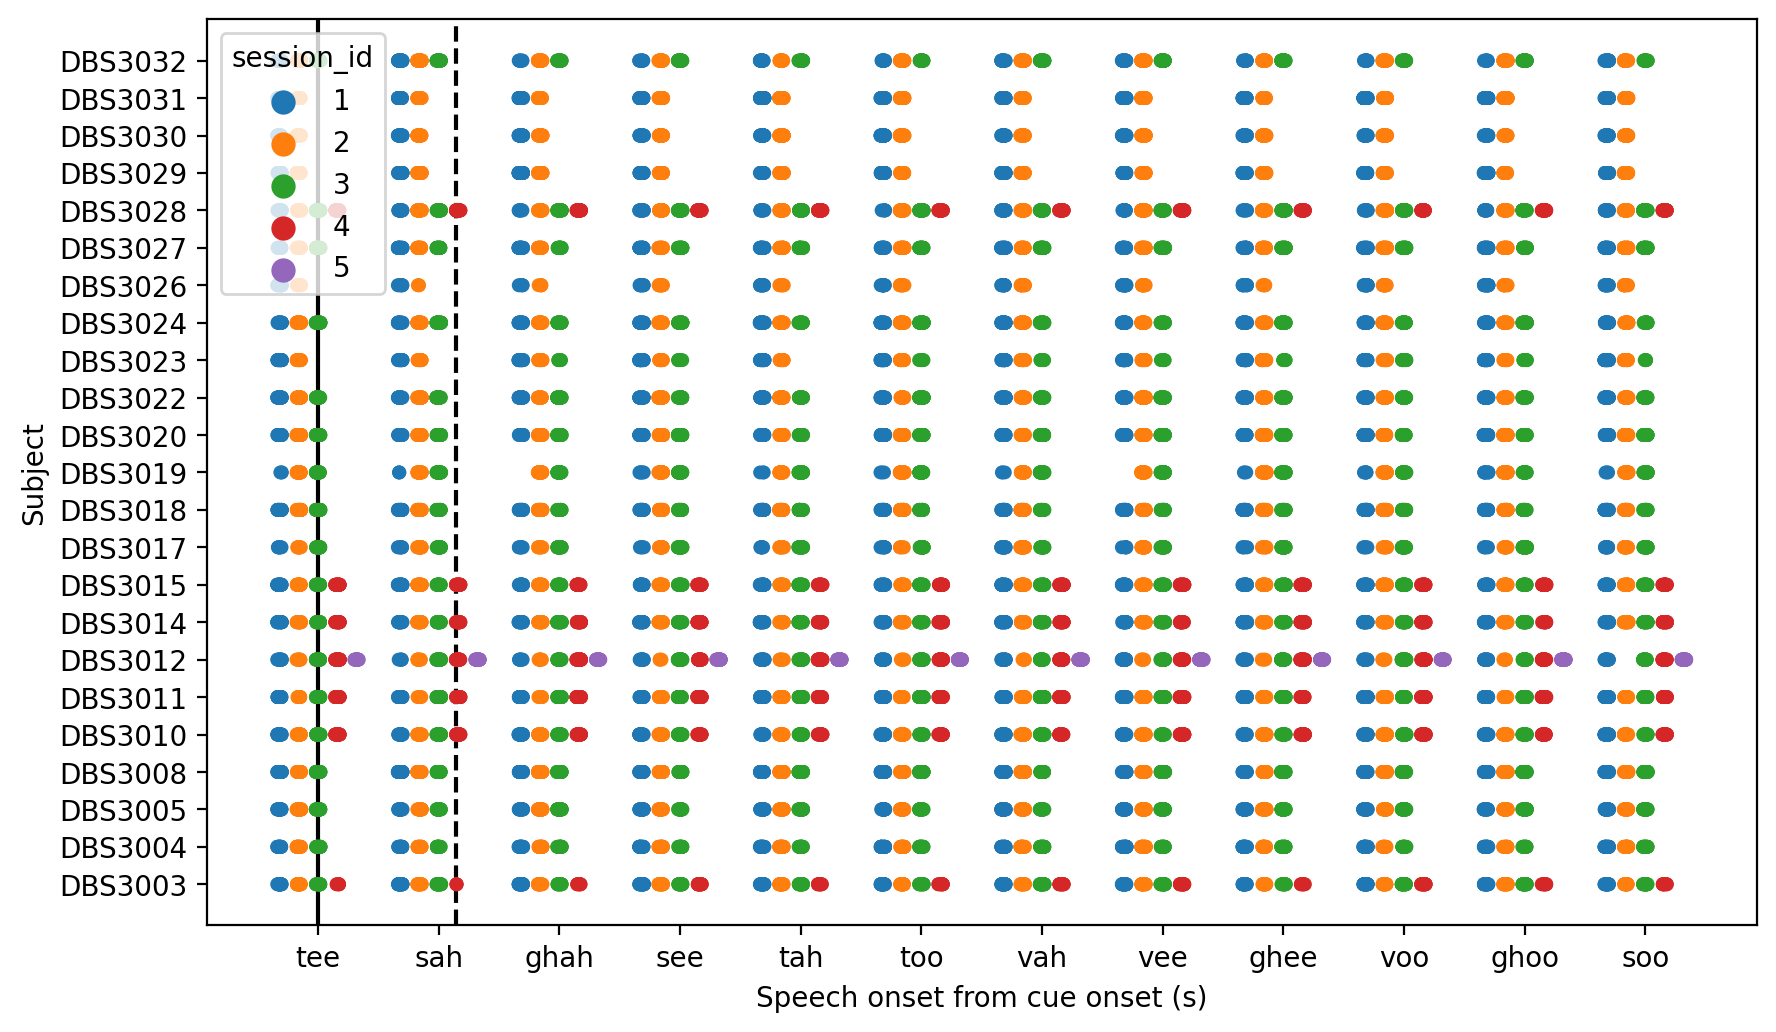

In [109]:
fig, axs = plt.subplots(1, 1, figsize=(10, 6), dpi=200)

sns.stripplot(data=all_subj_triplet, x='stim1', y='subject', hue='session_id', 
            ax=axs, dodge=1)

axs.axvline(all_subj_triplet.duration_x.mean()+1, label='Cue offset', c='k', linestyle='--')
axs.axvline(0, label='Cue onset', c='k')
axs.set_ylabel('Subject')
axs.set_xlabel('Speech onset from cue onset (s)')

#plt.legend()
plt.plot();

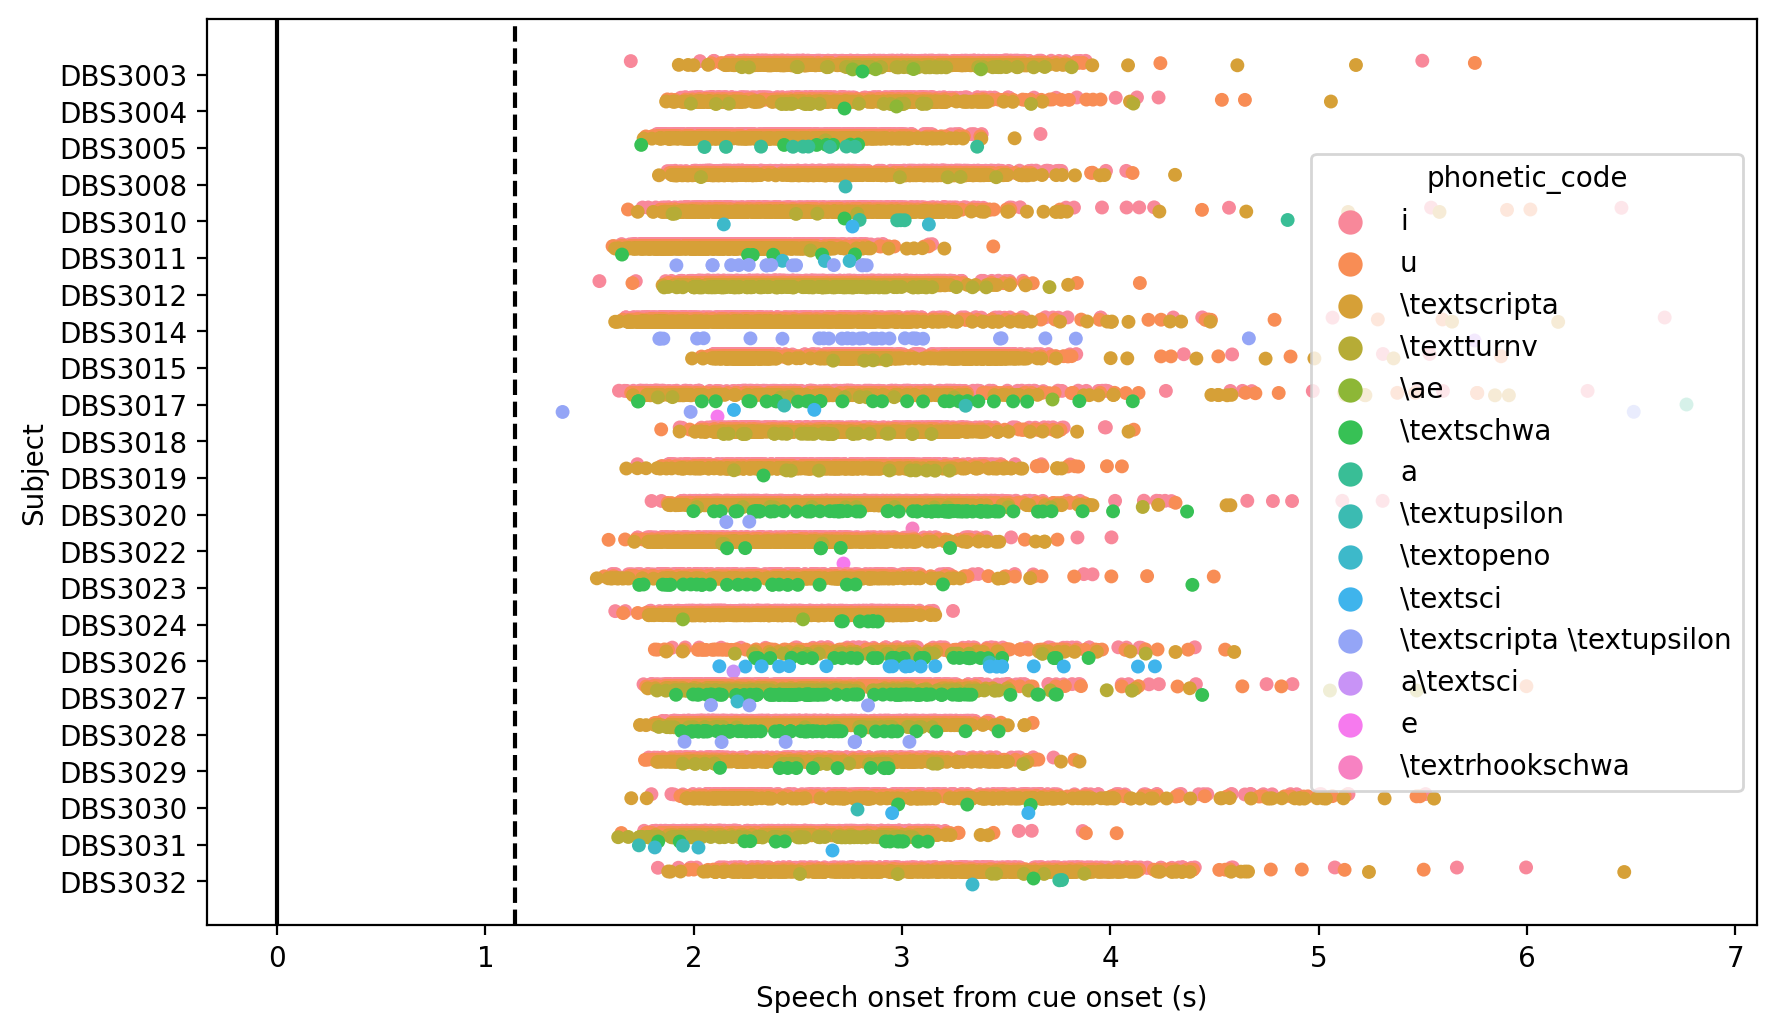

In [110]:
fig, axs = plt.subplots(1, 1, figsize=(10, 6), dpi=200)

sns.stripplot(data=all_subj_triplet, x='cue_speech_lag', y='subject', hue='phonetic_code', 
            ax=axs, dodge=1)

axs.axvline(all_subj_triplet.duration_x.mean()+1, label='Cue offset', c='k', linestyle='--')
axs.axvline(0, label='Cue onset', c='k')
axs.set_ylabel('Subject')
axs.set_xlabel('Speech onset from cue onset (s)')

#plt.legend()
plt.plot();

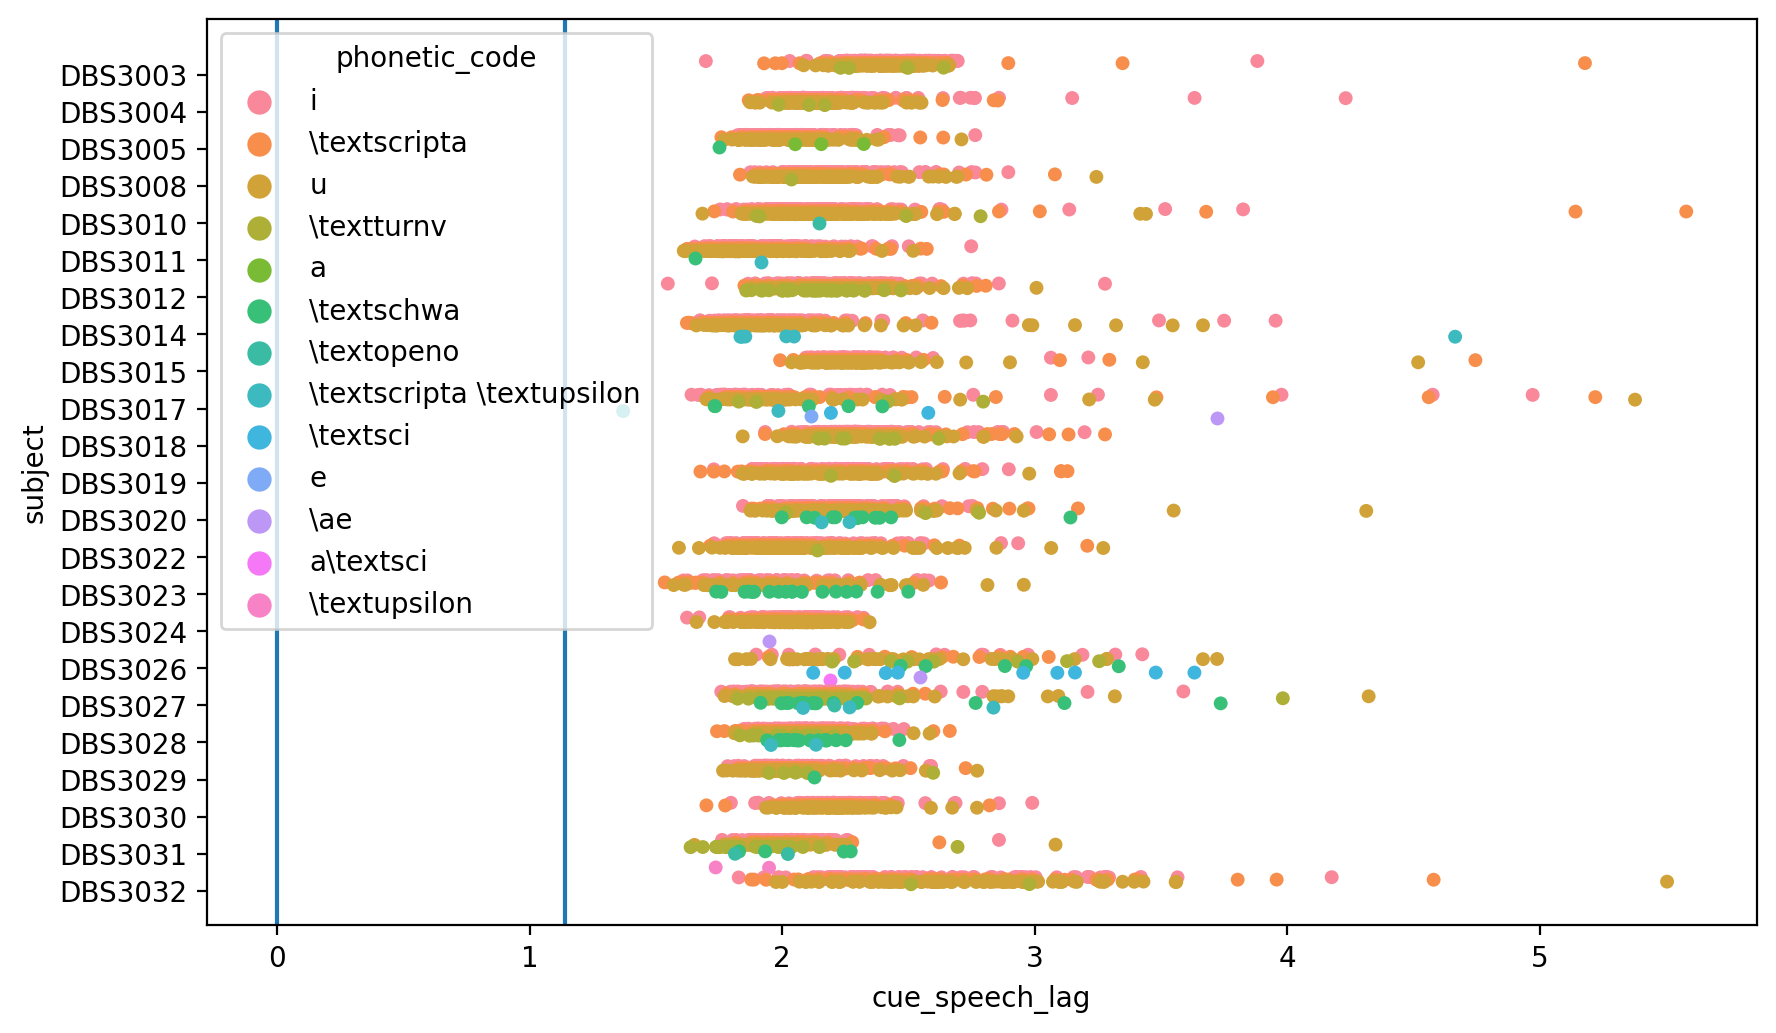

In [86]:
fig, axs = plt.subplots(1, 1, figsize=(10, 6), dpi=200)

sns.stripplot(data=all_subj_df_1, x='cue_speech_lag', y='subject', hue='phonetic_code', 
            ax=axs, dodge=1, orient='h')
axs.axvline(all_subj_df_1.duration_x.mean()+1, label='Cue offset')
axs.axvline(0, label='Cue onset')
#plt.legend()
plt.plot();

In [70]:
all_subj_df.columns

Index(['starts_x', 'ends_x', 'duration_x', 'cons_onset', 'trial_id',
       'session_id', 'syl_id', 'channel', 'fundamental_freq', 'type', 'stim_x',
       'stim_volume_x', 'phonetic_code', 'accuracy', 'disorder', 'rms_audio_p',
       'subject', 'freq2', 'discont', 'contrun_id', 't', 't2', 't3',
       'stim_factor', 'spl', 'before_time', 'starts_y', 'ends_y', 'duration_y',
       'stim_y', 'stim_volume_y', 'stim_C', 'stim_V', 'duration_C',
       'duration_V', 'cue_speech_lag'],
      dtype='object')

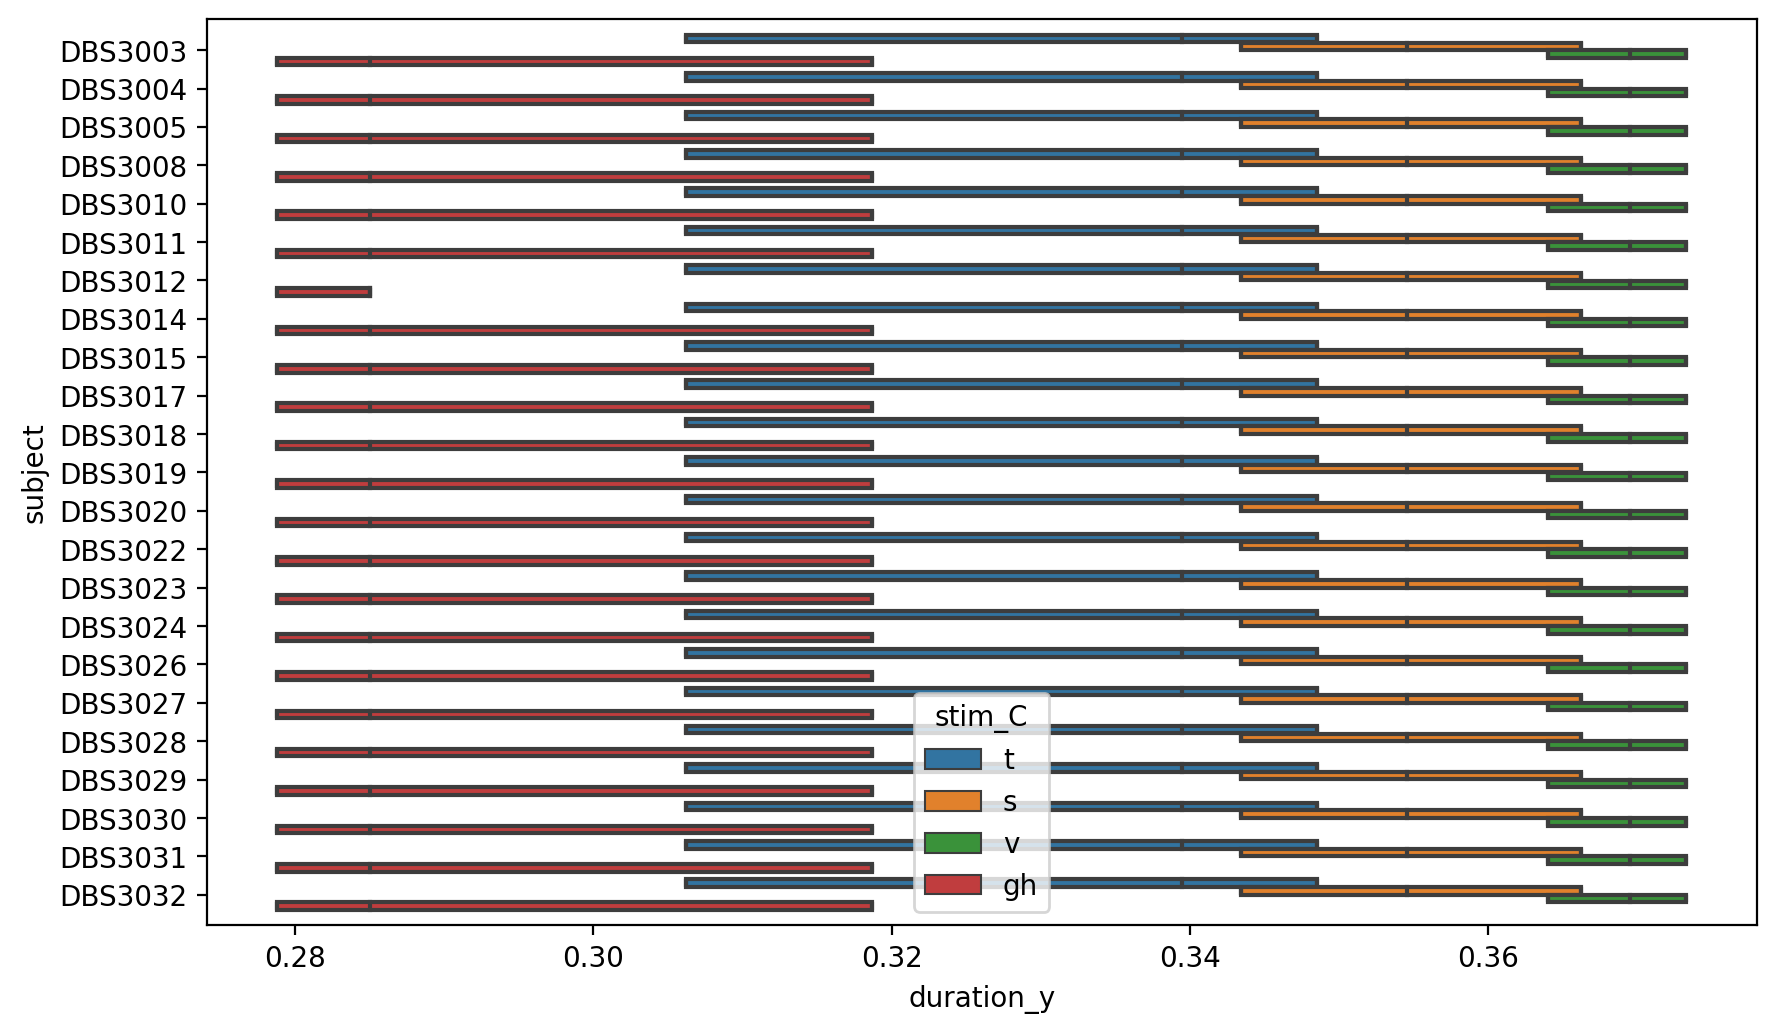

In [72]:
fig, axs = plt.subplots(1, 1, figsize=(10, 6), dpi=200)

sns.boxplot(data=all_subj_df, x='duration_y', y='subject', hue='stim_C', 
            ax=axs, showfliers=0, orient='h')
#axs.axvline(all_subj_df_1.duration_x.mean()+1, label='Cue offset')
#axs.axvline(0, label='Cue onset')
#plt.legend()
plt.plot();

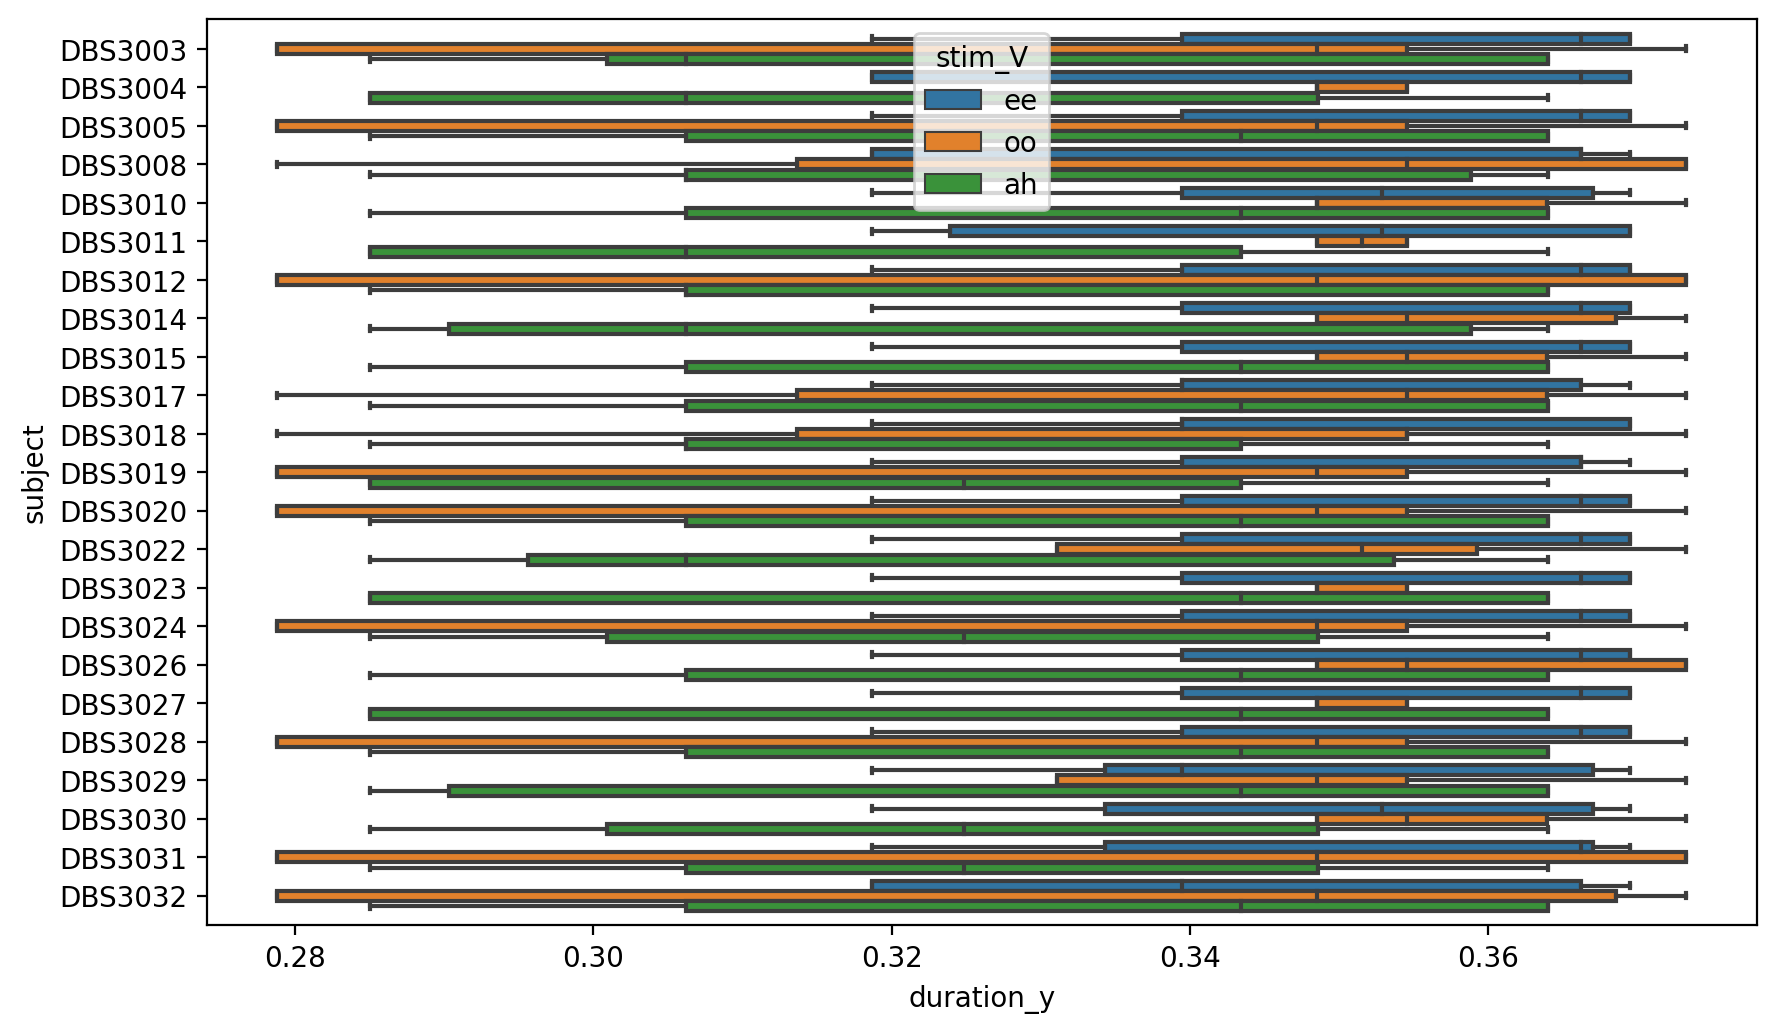

In [73]:
fig, axs = plt.subplots(1, 1, figsize=(10, 6), dpi=200)

sns.boxplot(data=all_subj_df, x='duration_y', y='subject', hue='stim_V', 
            ax=axs, showfliers=0, orient='h')
#axs.axvline(all_subj_df_1.duration_x.mean()+1, label='Cue offset')
#axs.axvline(0, label='Cue onset')
#plt.legend()
plt.plot();

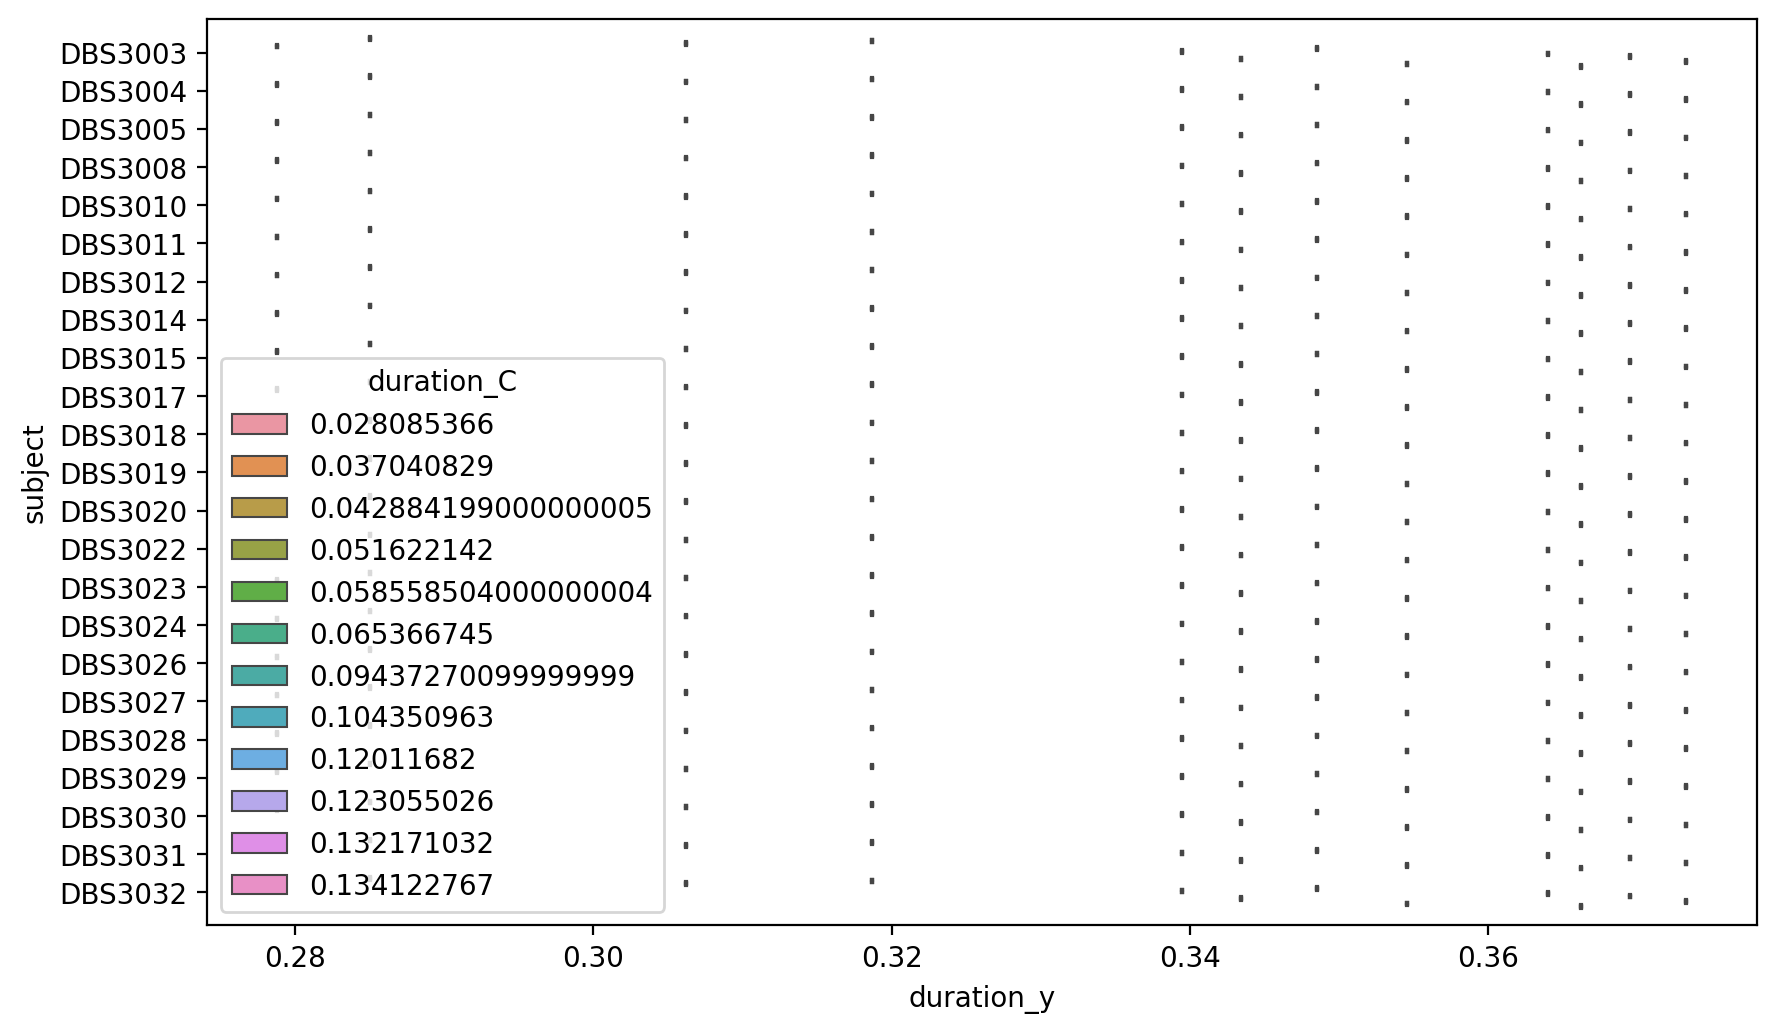

In [74]:
fig, axs = plt.subplots(1, 1, figsize=(10, 6), dpi=200)

sns.boxplot(data=all_subj_df, x='duration_y', y='subject', hue='duration_C', 
            ax=axs, showfliers=0, orient='h')
#axs.axvline(all_subj_df_1.duration_x.mean()+1, label='Cue offset')
#axs.axvline(0, label='Cue onset')
#plt.legend()
plt.plot();